
<div dir="rtl">
<h1></h1>
 <p>  ابتدا برخی از هایپر پارامتر هارا مقدار می دهیم مثل اندازه ورودی 
 gan
 که همان
 latent_dim
 هست و همچنین تعداد ایپاک ها که 30 ایپاک است و سایز بچ ها که 64 در نظر می گیریم
 و همچنین نرخ یادگیری که 0.0002 است 
 و
 image_shape
    که اندازه تصاویر ورودی است.
  </p>

In [12]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
import imageio.v2 as imageio
import os

latent_dim = 100
learning_rate = 0.0002
epochs = 30
batch_size = 64
Tensor = torch.FloatTensor
image_shape = (1, 28, 28)


<div dir="rtl">
<h1>Generator و Discriminator</h1>
    <p>  
در 
Gan
نیاز به دو مدل 
Generator
و
Discriminator
داریم که 
Generator
با گرفتن یک بردار نویز به عنوان ورودی تصویری تولید می کند و
Discriminator
با گرفتن یک تصویر به عنوان ورودی تصمیم می گیرد که تصویر ورودی واقعی است یا توسط
Generator
تولید شده است که در اصل  یکی 
classifier
استه که عددی بین 0 تا 1 برمی گرداند که نشان دهنده احتمال واقعی بودن 
تصویر ورودی است.
 </p>
<h2> Generator</h2>
 <p>
همانطور که اشاره کردیم
Generator
با گرفتن یک بردار نویز به عنوان ورودی تصویری تولید می کند. برای این کار از یک شبکه
CNN
استفاده می کنیم 
(چون میخواهسم با تصاویر کار کنیم و برای تصاویر بهتر عمل میکند از 
fully connected)
 که از چند لایه
Conv2DTranspose
و
BatchNormalization
و
LeakyReLU
تشکیل شده است. 
همچنین در ابتدا از یک لایه
Linear
برای تبدیل بردار نویز به یک بردار ویژگی استفاده می کنیم.
 </p>
 <p>
در ادامه شرح می دهیم که هر لایه چه کاری انجام می دهد و از چه
shape
ورودی 
به چه 
shape
خروجی تبدیل می کند.
    </p>
     <p>
    
لازم به ذکر اس 
batch_size
که در ادامه به آن اشاره می کنیم برابر با 64 است.
</p>
<p>
Linear:
شکل ورودی: (batch_size, 100)
شکل خروجی: (batch_size, 128 * 7 * 7)
<br>
BatchNorm2d:
شکل ورودی: (batch_size, 128, 7, 7)
شکل خروجی: (batch_size, 128, 7, 7)

<br>
Upsample:
شکل ورودی: (batch_size, 128, 7, 7)
شکل خروجی: (batch_size, 128, 14, 14)

<br>
Conv2d:
شکل ورودی: (batch_size, 128, 14, 14)
شکل خروجی: (batch_size, 128, 14, 14)

<br>
BatchNorm2d:
شکل ورودی: (batch_size, 128, 14, 14)
شکل خروجی: (batch_size, 128, 14, 14)

<br>
LeakyReLU:
شکل ورودی: (batch_size, 128, 14, 14)
شکل خروجی: (batch_size, 128, 14, 14)

<br>
Upsample:
شکل ورودی: (batch_size, 128, 14, 14)
شکل خروجی: (batch_size, 128, 28, 28)

<br>
Conv2d:
شکل ورودی: (batch_size, 128, 28, 28)
شکل خروجی: (batch_size, 64, 28, 28)

<br>
BatchNorm2d (دومین نمونه):
شکل ورودی: (batch_size, 64, 28, 28)
شکل خروجی: (batch_size, 64, 28, 28)

<br>
LeakyReLU (دومین نمونه):
شکل ورودی: (batch_size, 64, 28, 28)
شکل خروجی: (batch_size, 64, 28, 28)

<br>
Conv2d (سومین نمونه):
شکل ورودی: (batch_size, 64, 28, 28)
شکل خروجی: (batch_size, 1, 28, 28)

<br>
Tanh:
شکل ورودی: (batch_size, 1, 28, 28)
شکل خروجی: (batch_size, 1, 28, 28)
<br>
هدف: اعمال تابع Tanh برای مقیاس‌گذاری مقادیر خروجی در بازه [-1, 1].
زیرا در 
dataloader
با استفاده از 
transform
toTensor
و
normalize
مقادیر پیکسل در بازه 
[-1, 1]
قرار می‌گیرند.
 </p>

<h2> Discriminator</h2>
    <p>
    همانطور که اشاره کردیم
Discriminator
با گرفتن یک تصویر به عنوان ورودی تصمیم می گیرد که تصویر ورودی واقعی است یا توسط
Generator
تولید شده است .
برای این کار از یک شبکه
CNN
استفاده می کنیم که از چند لایه
Conv2D
و
BatchNormalization
و
LeakyReLU
تشکیل شده است.
    </p>
<p>
در ادامه شرح می دهیم که هر لایه چه کاری انجام می دهد و از چه
shape   
ورودی
به چه
shape
خروجی تبدیل می کند.
    </p>
    <p>
    
 لازم به ذکر اس 
 batch_size
 که در ادامه به آن اشاره می کنیم برابر با 64 است.
</p>
<p>
Conv2d (نمونه اول):
شکل ورودی: (batch_size, 1, 28, 28)
شکل خروجی: (batch_size, 16, 14, 14)
هدف: اعمال کانولوشن با ۱۶ فیلتر و کاهش اندازه تصویر ورودی به ۱۴x۱۴. پدینگ ۱ باعث می‌شود که ابعاد فضایی نصف شوند.
<br>
LeakyReLU (نمونه اول):
شکل ورودی: (batch_size, 16, 14, 14)
شکل خروجی: (batch_size, 16, 14, 14)
<br>
Dropout2d (نمونه اول):
شکل ورودی: (batch_size, 16, 14, 14)
شکل خروجی: (batch_size, 16, 14, 14)
<br>
Conv2d (نمونه دوم):
شکل ورودی: (batch_size, 16, 14, 14)
شکل خروجی: (batch_size, 32, 7, 7)
هدف: اعمال کانولوشن با ۳۲ فیلتر و کاهش اندازه تصویر ورودی به ۷x۷. پدینگ ۱ باعث می‌شود که ابعاد فضایی نصف شوند.
<br>
LeakyReLU (نمونه دوم):
شکل ورودی: (batch_size, 32, 7, 7)
شکل خروجی: (batch_size, 32, 7, 7)
<br>
Dropout2d (نمونه دوم):
شکل ورودی: (batch_size, 32, 7, 7)
شکل خروجی: (batch_size, 32, 7, 7)
از 
Dropout2d
برای جلوگیری از بیش‌برازش استفاده می‌شود.
<br>
Linear:
شکل ورودی: (batch_size, 32 * 7 * 7)
شکل خروجی: (1)
و در آخر س
sigmoid
استفاده می کنیم تا خروجی بین 0 تا 1 باشد.
</p>



In [13]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.init_size = 7  
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(16, 32, 3, 2, 1),
            nn.BatchNorm2d(32, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
        )

     
        self.adv_layer = nn.Sequential(nn.Linear(128 * 2* 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity





<div dir="rtl">
 <p>  
 مدل های 
Generator
و
Discriminator
را به صورت 
object
ایجاد می کنیم و از تابع
bcross_entropy
برای محاسبه 
استفاده می کنیم.
زیرا این تابع برای مسائل دسته بندی استفاده می شود و
Discriminator
به عنوان یک
classifier
عمل می کند.
  </p>

  <p>
  سپس 
optimizer
های
Adam
را برای هر دو مدل ایجاد می کنیم.
که دو 
optimizer
متفاوت داریم برای
generator
فقط پارامتر های
generator
و برای
discriminator
پارامتر های
discriminator
را دارد و 
update
می کند.
همچنین برای استفاده از 
GPU
todevice
را برای هر دو مدل اعمال می کنیم
و این کار باعث بالا رفتن سرعت آموزش می شود.
  </p>

In [14]:
generator = Generator(latent_dim)
discriminator = Discriminator()

adversarial_loss = torch.nn.BCELoss()

optimizer_generator = torch.optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (torch.cuda.is_available())
discriminator.to(device)
generator.to(device)



True


Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

<
<div dir="rtl">
<h2>data loader</h2>
 <p>
با 
dataloader
می خواهیم تصاویر را بارگذاری کنیم
و از تابع
transforms
برای تبدیل تصاویر استفاده می کنیم.
که از تابع
ToTensor
برای تبدیل تصاویر به تنسور و از تابع
Normalize
استفاده می کنیم تا مقادیر پیکسل ها را در بازه
[-1, 1]
قرار دهیم.
 </p>

In [15]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

data_loader = DataLoader(datasets.MNIST('./data/mnist', train=True, download=True, transform=transform),
                         batch_size=batch_size, shuffle=True)


<div dir="rtl">
<h1>فرایند یاد گیری</h1>
 <p>  
ابتدا 
epoch
هارا طی میکنیم و 
در هر ایپاک
بچ هارا طی می کنیم که هر بچ را از 
data loader
بارگذاری می کنیم.
در طی کردن هر بچ
ابتدا
عکس های آن بچ را که گرفتیم
سپس 
real_output
را تولید میکنیم که برداری از صفر هاست و اندازه آن برابر با اندازه بچ است.
سپس
fake_output
را تولید میکنیم که برداری از یک هاست و اندازه آن برابر با اندازه بچ است.
که در ادامه از آن ها استفاده می کنیم.
  </p>
  <p>  
  
اول بردار رندم به اندازه سایز
latent_dim
را تولید می کنیم
و از آن برای تولید تصاویر استفاده می کنیم
به این صورت که به تابع 
generator
بردار رندم را می دهیم و تصویری تولید می کند
که در 
generated_images
ذخیره می کنیم.
  </p>
  <p>  
<h2> آموزش discriminator</h2>
 <p>
ابتدا می خواهیم 
discriminator
را آموزش دهیم.
برای این کار اول 
optimizer.zero_grad()
را فراخوانی می کنیم تا گرادیان های قبلی را صفر کند.
سپس
real_loss
را برای عکس های واقعی محاسبه می کنیم به این صورت که باید خروجی عکس های واقعی را یک بدهد پس به 
loos_function
real_outputs
را می دهیم
و سپس عکس های تولید شده
(generated_images)
را به
discriminator
می دهیم و خروجی آن را به
loos_function
می دهیم
و باید خروجی این هارا 0 یا همان غیر واقعی تشخیص داده باشد پس 
facke_output
را به آن می دهیم.
پس از محاسبه 
loss
تابع
backward
را فراخوانی می کنیم تا گرادیان ها محاسبه شود
و 
step
برای
discriminator_optimizer
تا پارامتر ها آپدیت شوند.
<h2> آموزش generator</h2>
  <p>
در این قسمت می خواهیم 
generator
را آموزش دهیم.
برای این کار اول
optimizer_generatio.zero_grad
و
optimizer_discriminator.zero_grad
را فراخوانی می کنیم تا گرادیان های قبلی را صفر کند.
نیاز داریم 
هردو 
optimizer
را صفر کنیم چون می خواهیم
generator
را آموزش دهیم و برای آموزش
generator
باید گرادیان های آن را محاسبه کنیم و گرادیان ها در قسمت 
generator
پدرشان در قسمت
discriminator
است و به 
generator
منتقل می شوند
پس باید گرادیان های قبلی را صفر کنیم.
حال خروجی
discriminator
در 
عکس های تولید شده توسط 
generator
و لیبل آن ها 
که باید 
real_output
باشد را به 
تابع
loss
می دهیم زیرا هدف 
generator
این است که
discriminator
را به اشتباه بیندازد تا خروجی را 1 یا همان عکس واقعی تشخیص دهد.
سپس تابع لاس که برابر مجموع دو لاس است را 
backward
می کنیم 
تا گرادیان ها محاسبه شود.
سپس با فراخانی 
step
پارامترهای
generator
را آپدیت می کنیم.
در ادامه عکس هارا نمایش و ذخیره می کنیم.

  </p>

[Epoch    1/30] [Batch   99/938] ---> [D Loss: 0.683306] [G Loss: 0.645598]
[Epoch    1/30] [Batch  199/938] ---> [D Loss: 0.681869] [G Loss: 0.678887]
[Epoch    1/30] [Batch  299/938] ---> [D Loss: 0.698238] [G Loss: 0.694329]
[Epoch    1/30] [Batch  399/938] ---> [D Loss: 0.687436] [G Loss: 0.668491]
[Epoch    1/30] [Batch  499/938] ---> [D Loss: 0.666273] [G Loss: 0.704231]
[Epoch    1/30] [Batch  599/938] ---> [D Loss: 0.681441] [G Loss: 0.738805]
[Epoch    1/30] [Batch  699/938] ---> [D Loss: 0.677584] [G Loss: 0.658340]
[Epoch    1/30] [Batch  799/938] ---> [D Loss: 0.685672] [G Loss: 0.692090]
[Epoch    1/30] [Batch  899/938] ---> [D Loss: 0.684948] [G Loss: 0.713273]


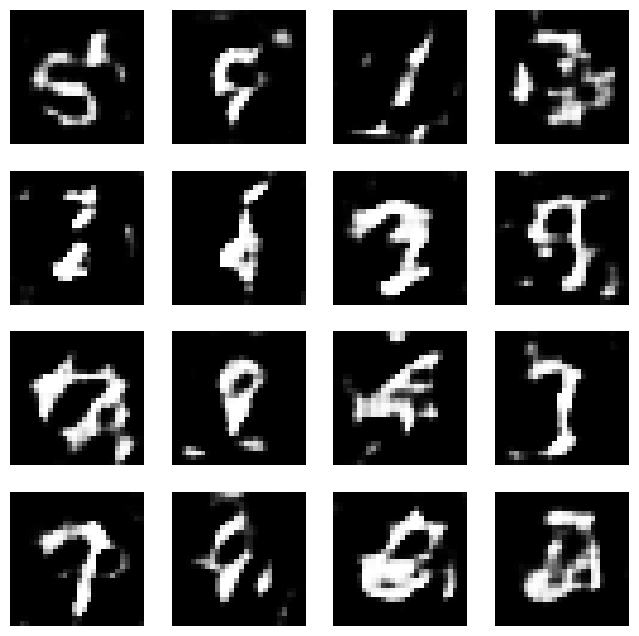

[Epoch    2/30] [Batch   99/938] ---> [D Loss: 0.669715] [G Loss: 0.749300]
[Epoch    2/30] [Batch  199/938] ---> [D Loss: 0.663157] [G Loss: 0.757347]
[Epoch    2/30] [Batch  299/938] ---> [D Loss: 0.685168] [G Loss: 0.661035]
[Epoch    2/30] [Batch  399/938] ---> [D Loss: 0.652849] [G Loss: 0.733812]
[Epoch    2/30] [Batch  499/938] ---> [D Loss: 0.679160] [G Loss: 0.766918]
[Epoch    2/30] [Batch  599/938] ---> [D Loss: 0.661941] [G Loss: 0.685859]
[Epoch    2/30] [Batch  699/938] ---> [D Loss: 0.670448] [G Loss: 0.817701]
[Epoch    2/30] [Batch  799/938] ---> [D Loss: 0.640199] [G Loss: 0.773431]
[Epoch    2/30] [Batch  899/938] ---> [D Loss: 0.676751] [G Loss: 0.691328]


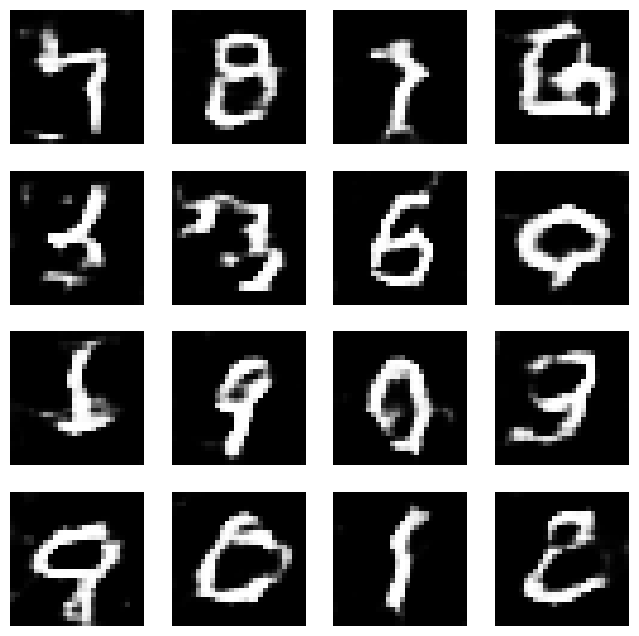

[Epoch    3/30] [Batch   99/938] ---> [D Loss: 0.596797] [G Loss: 0.869974]
[Epoch    3/30] [Batch  199/938] ---> [D Loss: 0.649077] [G Loss: 0.824439]
[Epoch    3/30] [Batch  299/938] ---> [D Loss: 0.611111] [G Loss: 0.823751]
[Epoch    3/30] [Batch  399/938] ---> [D Loss: 0.654981] [G Loss: 0.750009]
[Epoch    3/30] [Batch  499/938] ---> [D Loss: 0.644592] [G Loss: 0.731742]
[Epoch    3/30] [Batch  599/938] ---> [D Loss: 0.673592] [G Loss: 0.831555]
[Epoch    3/30] [Batch  699/938] ---> [D Loss: 0.686740] [G Loss: 0.674639]
[Epoch    3/30] [Batch  799/938] ---> [D Loss: 0.662696] [G Loss: 0.892732]
[Epoch    3/30] [Batch  899/938] ---> [D Loss: 0.631979] [G Loss: 0.813789]


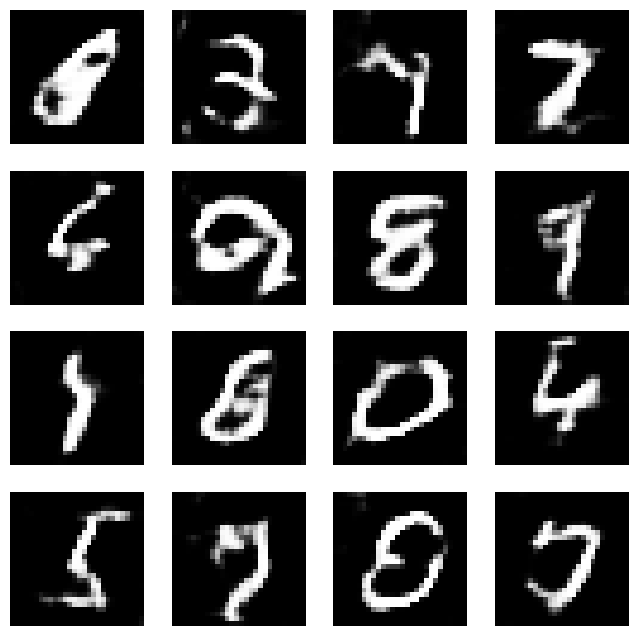

[Epoch    4/30] [Batch   99/938] ---> [D Loss: 0.661315] [G Loss: 0.766780]
[Epoch    4/30] [Batch  199/938] ---> [D Loss: 0.684342] [G Loss: 0.855301]
[Epoch    4/30] [Batch  299/938] ---> [D Loss: 0.635615] [G Loss: 0.762373]
[Epoch    4/30] [Batch  399/938] ---> [D Loss: 0.630392] [G Loss: 0.862362]
[Epoch    4/30] [Batch  499/938] ---> [D Loss: 0.604047] [G Loss: 0.766015]
[Epoch    4/30] [Batch  599/938] ---> [D Loss: 0.636603] [G Loss: 0.874259]
[Epoch    4/30] [Batch  699/938] ---> [D Loss: 0.632413] [G Loss: 1.054470]
[Epoch    4/30] [Batch  799/938] ---> [D Loss: 0.630635] [G Loss: 0.612520]
[Epoch    4/30] [Batch  899/938] ---> [D Loss: 0.594829] [G Loss: 0.867276]


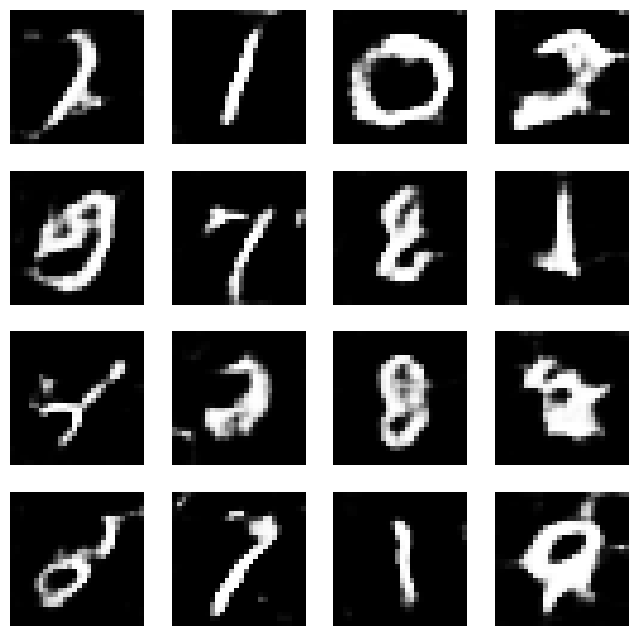

[Epoch    5/30] [Batch   99/938] ---> [D Loss: 0.682046] [G Loss: 0.797905]
[Epoch    5/30] [Batch  199/938] ---> [D Loss: 0.641642] [G Loss: 0.908764]
[Epoch    5/30] [Batch  299/938] ---> [D Loss: 0.616812] [G Loss: 1.029696]
[Epoch    5/30] [Batch  399/938] ---> [D Loss: 0.657704] [G Loss: 0.718082]
[Epoch    5/30] [Batch  499/938] ---> [D Loss: 0.656301] [G Loss: 0.722389]
[Epoch    5/30] [Batch  599/938] ---> [D Loss: 0.610988] [G Loss: 0.917779]
[Epoch    5/30] [Batch  699/938] ---> [D Loss: 0.647783] [G Loss: 0.748294]
[Epoch    5/30] [Batch  799/938] ---> [D Loss: 0.759231] [G Loss: 0.822412]
[Epoch    5/30] [Batch  899/938] ---> [D Loss: 0.636452] [G Loss: 0.864040]


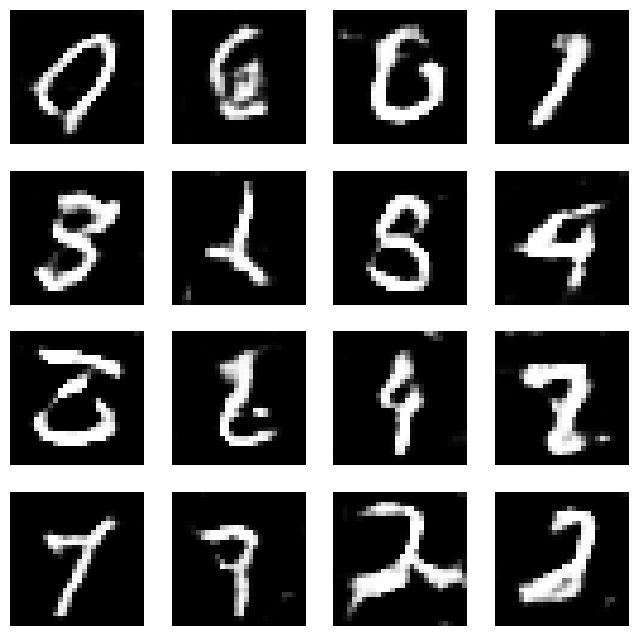

[Epoch    6/30] [Batch   99/938] ---> [D Loss: 0.522108] [G Loss: 0.767899]
[Epoch    6/30] [Batch  199/938] ---> [D Loss: 0.552068] [G Loss: 0.840141]
[Epoch    6/30] [Batch  299/938] ---> [D Loss: 0.693810] [G Loss: 0.836663]
[Epoch    6/30] [Batch  399/938] ---> [D Loss: 0.655086] [G Loss: 0.845127]
[Epoch    6/30] [Batch  499/938] ---> [D Loss: 0.639348] [G Loss: 0.909592]
[Epoch    6/30] [Batch  599/938] ---> [D Loss: 0.635693] [G Loss: 0.867301]
[Epoch    6/30] [Batch  699/938] ---> [D Loss: 0.663163] [G Loss: 0.815345]
[Epoch    6/30] [Batch  799/938] ---> [D Loss: 0.638712] [G Loss: 0.787077]
[Epoch    6/30] [Batch  899/938] ---> [D Loss: 0.658509] [G Loss: 0.723054]


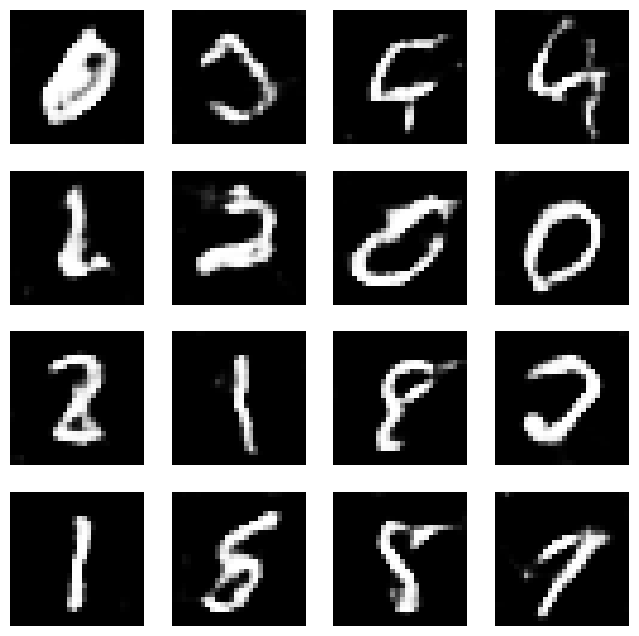

[Epoch    7/30] [Batch   99/938] ---> [D Loss: 0.670887] [G Loss: 0.918146]
[Epoch    7/30] [Batch  199/938] ---> [D Loss: 0.593346] [G Loss: 0.643203]
[Epoch    7/30] [Batch  299/938] ---> [D Loss: 0.604867] [G Loss: 0.582800]
[Epoch    7/30] [Batch  399/938] ---> [D Loss: 0.566408] [G Loss: 0.934596]
[Epoch    7/30] [Batch  499/938] ---> [D Loss: 0.587814] [G Loss: 0.637188]
[Epoch    7/30] [Batch  599/938] ---> [D Loss: 0.562342] [G Loss: 0.846333]
[Epoch    7/30] [Batch  699/938] ---> [D Loss: 0.606797] [G Loss: 0.896522]
[Epoch    7/30] [Batch  799/938] ---> [D Loss: 0.525392] [G Loss: 1.194632]
[Epoch    7/30] [Batch  899/938] ---> [D Loss: 0.671063] [G Loss: 0.713058]


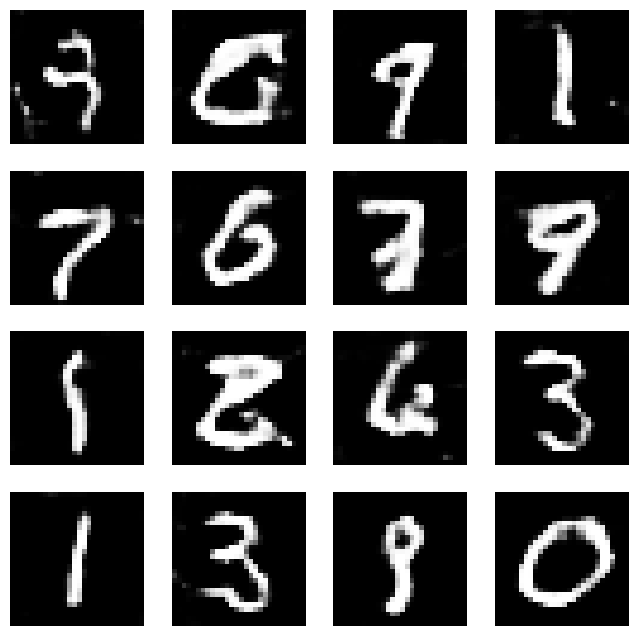

[Epoch    8/30] [Batch   99/938] ---> [D Loss: 0.722049] [G Loss: 0.736695]
[Epoch    8/30] [Batch  199/938] ---> [D Loss: 0.687840] [G Loss: 0.800825]
[Epoch    8/30] [Batch  299/938] ---> [D Loss: 0.546525] [G Loss: 0.943582]
[Epoch    8/30] [Batch  399/938] ---> [D Loss: 0.729773] [G Loss: 0.810920]
[Epoch    8/30] [Batch  499/938] ---> [D Loss: 0.560415] [G Loss: 0.752452]
[Epoch    8/30] [Batch  599/938] ---> [D Loss: 0.646734] [G Loss: 0.952300]
[Epoch    8/30] [Batch  699/938] ---> [D Loss: 0.591831] [G Loss: 0.860965]
[Epoch    8/30] [Batch  799/938] ---> [D Loss: 0.686689] [G Loss: 0.641991]
[Epoch    8/30] [Batch  899/938] ---> [D Loss: 0.630183] [G Loss: 0.966742]


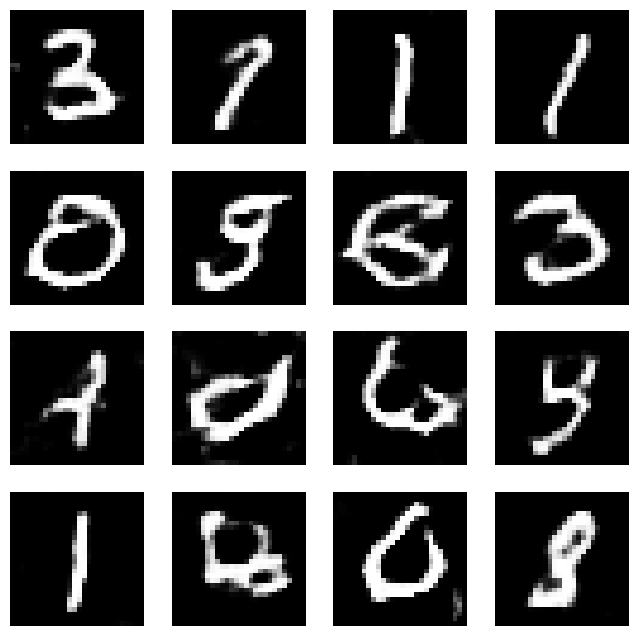

[Epoch    9/30] [Batch   99/938] ---> [D Loss: 0.575422] [G Loss: 1.081565]
[Epoch    9/30] [Batch  199/938] ---> [D Loss: 0.674266] [G Loss: 0.971121]
[Epoch    9/30] [Batch  299/938] ---> [D Loss: 0.543311] [G Loss: 0.941334]
[Epoch    9/30] [Batch  399/938] ---> [D Loss: 0.650207] [G Loss: 0.997471]
[Epoch    9/30] [Batch  499/938] ---> [D Loss: 0.632231] [G Loss: 0.981474]
[Epoch    9/30] [Batch  599/938] ---> [D Loss: 0.643030] [G Loss: 0.752741]
[Epoch    9/30] [Batch  699/938] ---> [D Loss: 0.588452] [G Loss: 0.955547]
[Epoch    9/30] [Batch  799/938] ---> [D Loss: 0.629510] [G Loss: 0.829677]
[Epoch    9/30] [Batch  899/938] ---> [D Loss: 0.743640] [G Loss: 0.504748]


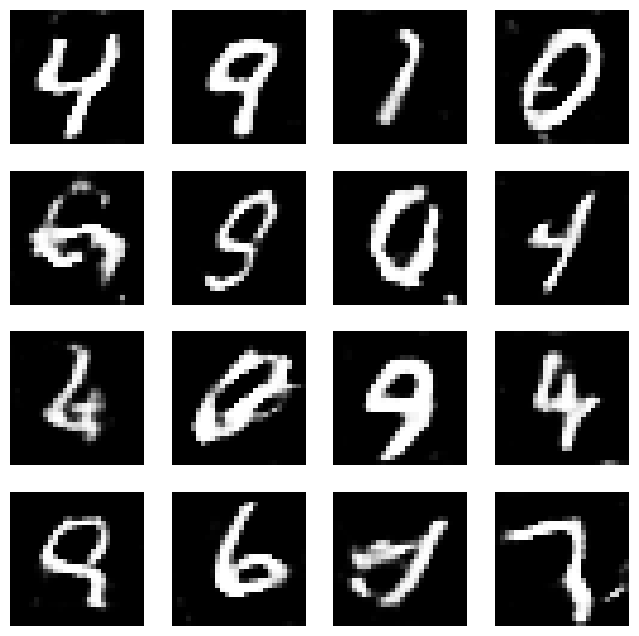

[Epoch   10/30] [Batch   99/938] ---> [D Loss: 0.616185] [G Loss: 0.776842]
[Epoch   10/30] [Batch  199/938] ---> [D Loss: 0.652682] [G Loss: 0.999347]
[Epoch   10/30] [Batch  299/938] ---> [D Loss: 0.693418] [G Loss: 1.167014]
[Epoch   10/30] [Batch  399/938] ---> [D Loss: 0.615722] [G Loss: 1.066739]
[Epoch   10/30] [Batch  499/938] ---> [D Loss: 0.736024] [G Loss: 0.981848]
[Epoch   10/30] [Batch  599/938] ---> [D Loss: 0.743490] [G Loss: 1.308781]
[Epoch   10/30] [Batch  699/938] ---> [D Loss: 0.655792] [G Loss: 0.838039]
[Epoch   10/30] [Batch  799/938] ---> [D Loss: 0.656540] [G Loss: 0.712462]
[Epoch   10/30] [Batch  899/938] ---> [D Loss: 0.677927] [G Loss: 0.761125]


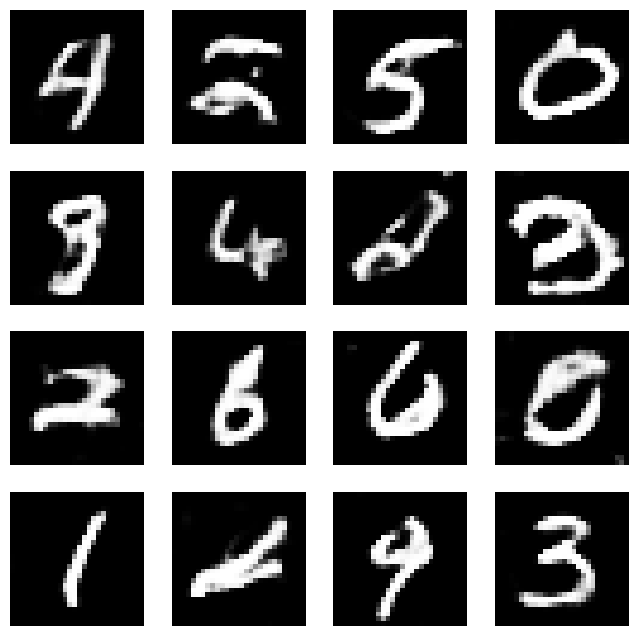

[Epoch   11/30] [Batch   99/938] ---> [D Loss: 0.767832] [G Loss: 0.843473]
[Epoch   11/30] [Batch  199/938] ---> [D Loss: 0.707200] [G Loss: 1.110909]
[Epoch   11/30] [Batch  299/938] ---> [D Loss: 0.578200] [G Loss: 0.886757]
[Epoch   11/30] [Batch  399/938] ---> [D Loss: 0.740760] [G Loss: 0.892206]
[Epoch   11/30] [Batch  499/938] ---> [D Loss: 0.651730] [G Loss: 1.198201]
[Epoch   11/30] [Batch  599/938] ---> [D Loss: 0.526728] [G Loss: 1.070239]
[Epoch   11/30] [Batch  699/938] ---> [D Loss: 0.565101] [G Loss: 0.712532]
[Epoch   11/30] [Batch  799/938] ---> [D Loss: 0.549352] [G Loss: 1.151113]
[Epoch   11/30] [Batch  899/938] ---> [D Loss: 0.407527] [G Loss: 0.753097]


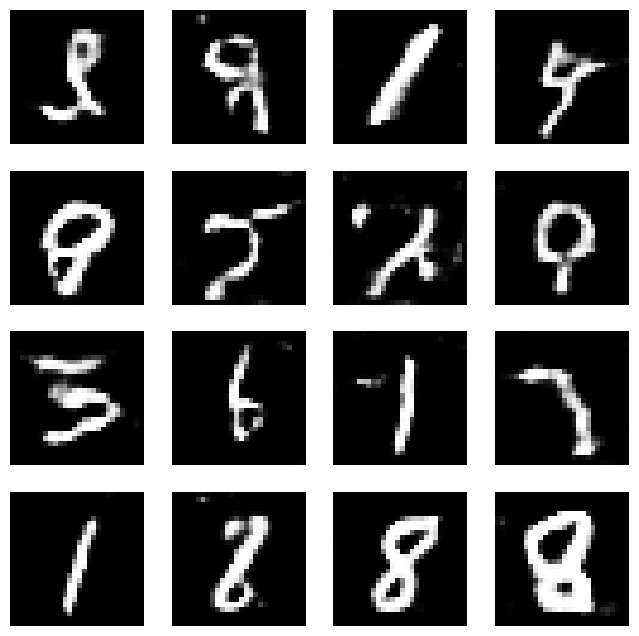

[Epoch   12/30] [Batch   99/938] ---> [D Loss: 0.560099] [G Loss: 0.963891]
[Epoch   12/30] [Batch  199/938] ---> [D Loss: 0.557514] [G Loss: 0.834750]
[Epoch   12/30] [Batch  299/938] ---> [D Loss: 0.551040] [G Loss: 0.910506]
[Epoch   12/30] [Batch  399/938] ---> [D Loss: 0.620796] [G Loss: 0.855132]
[Epoch   12/30] [Batch  499/938] ---> [D Loss: 0.697400] [G Loss: 1.032235]
[Epoch   12/30] [Batch  599/938] ---> [D Loss: 0.599130] [G Loss: 1.106117]
[Epoch   12/30] [Batch  699/938] ---> [D Loss: 0.476641] [G Loss: 1.424398]
[Epoch   12/30] [Batch  799/938] ---> [D Loss: 0.580959] [G Loss: 0.842613]
[Epoch   12/30] [Batch  899/938] ---> [D Loss: 0.550882] [G Loss: 1.063616]


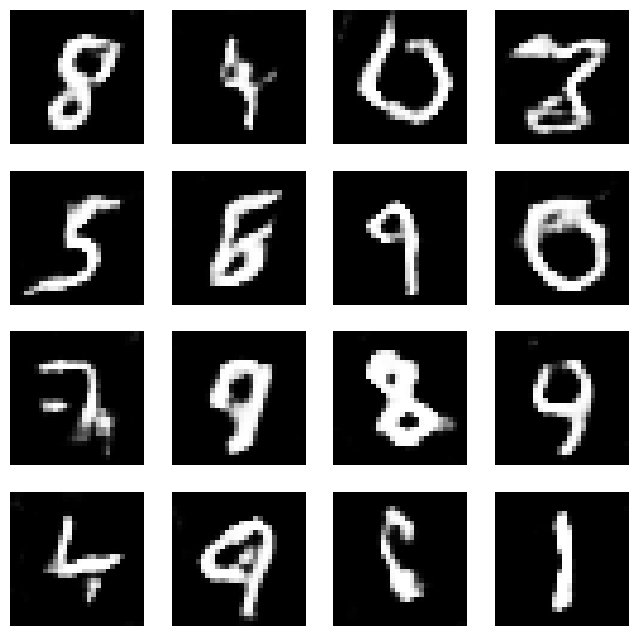

[Epoch   13/30] [Batch   99/938] ---> [D Loss: 0.629785] [G Loss: 1.017443]
[Epoch   13/30] [Batch  199/938] ---> [D Loss: 0.634409] [G Loss: 0.750075]
[Epoch   13/30] [Batch  299/938] ---> [D Loss: 0.429157] [G Loss: 1.120165]
[Epoch   13/30] [Batch  399/938] ---> [D Loss: 0.732390] [G Loss: 0.846346]
[Epoch   13/30] [Batch  499/938] ---> [D Loss: 0.556620] [G Loss: 1.106473]
[Epoch   13/30] [Batch  599/938] ---> [D Loss: 0.652569] [G Loss: 0.678892]
[Epoch   13/30] [Batch  699/938] ---> [D Loss: 0.553341] [G Loss: 0.913676]
[Epoch   13/30] [Batch  799/938] ---> [D Loss: 0.774591] [G Loss: 0.787713]
[Epoch   13/30] [Batch  899/938] ---> [D Loss: 0.751972] [G Loss: 0.952667]


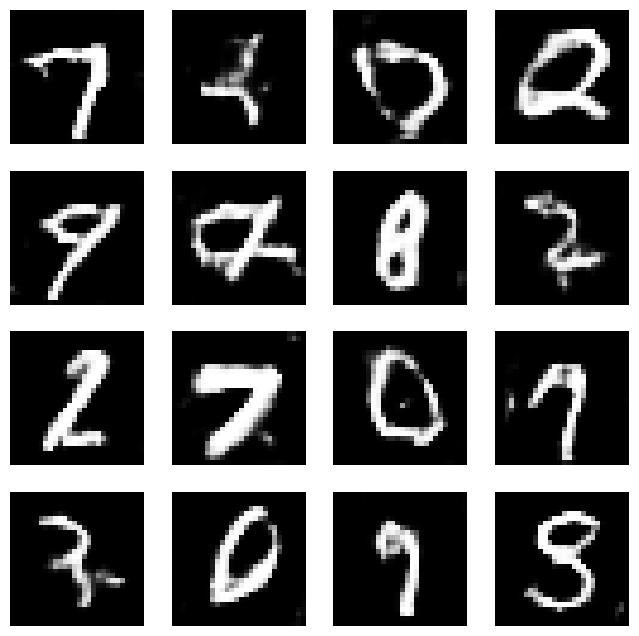

[Epoch   14/30] [Batch   99/938] ---> [D Loss: 0.679637] [G Loss: 1.113136]
[Epoch   14/30] [Batch  199/938] ---> [D Loss: 0.503927] [G Loss: 1.241485]
[Epoch   14/30] [Batch  299/938] ---> [D Loss: 0.593689] [G Loss: 1.003811]
[Epoch   14/30] [Batch  399/938] ---> [D Loss: 0.563551] [G Loss: 0.511915]
[Epoch   14/30] [Batch  499/938] ---> [D Loss: 0.670102] [G Loss: 0.961303]
[Epoch   14/30] [Batch  599/938] ---> [D Loss: 0.637852] [G Loss: 0.880265]
[Epoch   14/30] [Batch  699/938] ---> [D Loss: 0.729198] [G Loss: 1.183922]
[Epoch   14/30] [Batch  799/938] ---> [D Loss: 0.536343] [G Loss: 0.843885]
[Epoch   14/30] [Batch  899/938] ---> [D Loss: 0.851990] [G Loss: 0.966336]


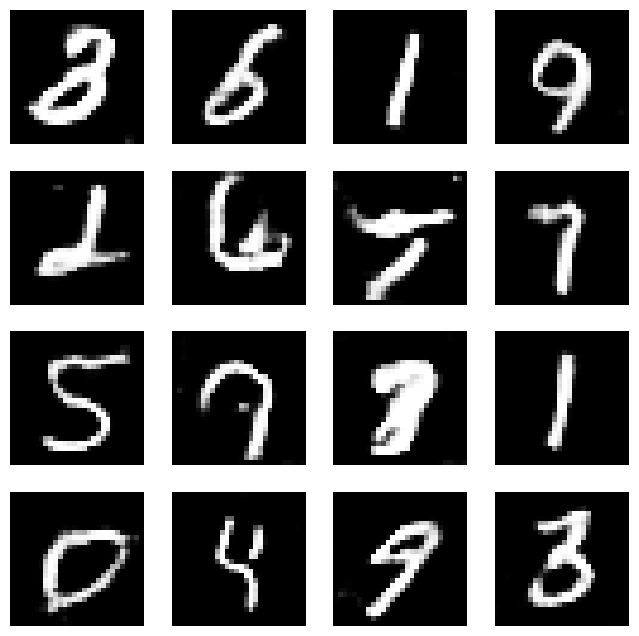

[Epoch   15/30] [Batch   99/938] ---> [D Loss: 0.623757] [G Loss: 1.091652]
[Epoch   15/30] [Batch  199/938] ---> [D Loss: 0.563516] [G Loss: 0.911703]
[Epoch   15/30] [Batch  299/938] ---> [D Loss: 0.595827] [G Loss: 0.838113]
[Epoch   15/30] [Batch  399/938] ---> [D Loss: 0.584593] [G Loss: 1.052904]
[Epoch   15/30] [Batch  499/938] ---> [D Loss: 0.624548] [G Loss: 1.018149]
[Epoch   15/30] [Batch  599/938] ---> [D Loss: 0.694244] [G Loss: 0.924511]
[Epoch   15/30] [Batch  699/938] ---> [D Loss: 0.740539] [G Loss: 0.745524]
[Epoch   15/30] [Batch  799/938] ---> [D Loss: 0.528279] [G Loss: 1.108342]
[Epoch   15/30] [Batch  899/938] ---> [D Loss: 0.665714] [G Loss: 0.945865]


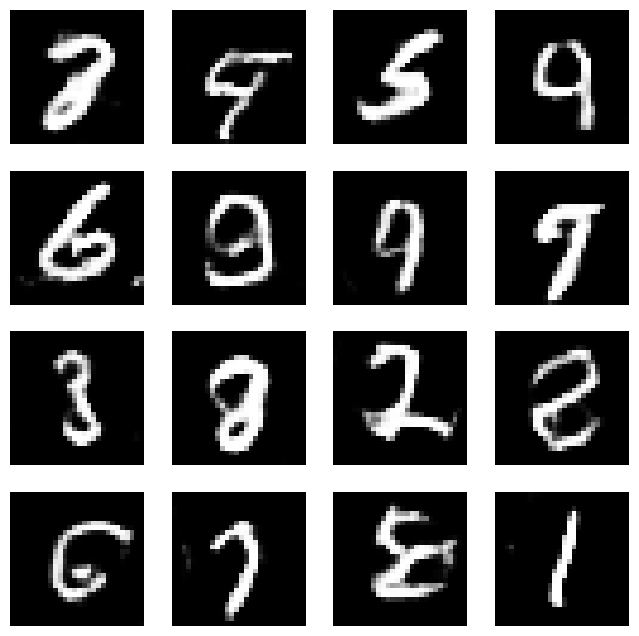

[Epoch   16/30] [Batch   99/938] ---> [D Loss: 0.656337] [G Loss: 1.277037]
[Epoch   16/30] [Batch  199/938] ---> [D Loss: 0.663935] [G Loss: 0.563381]
[Epoch   16/30] [Batch  299/938] ---> [D Loss: 0.616223] [G Loss: 0.971511]
[Epoch   16/30] [Batch  399/938] ---> [D Loss: 0.462253] [G Loss: 0.875105]
[Epoch   16/30] [Batch  499/938] ---> [D Loss: 0.808778] [G Loss: 0.701023]
[Epoch   16/30] [Batch  599/938] ---> [D Loss: 0.553212] [G Loss: 0.933832]
[Epoch   16/30] [Batch  699/938] ---> [D Loss: 0.524785] [G Loss: 0.947220]
[Epoch   16/30] [Batch  799/938] ---> [D Loss: 0.537643] [G Loss: 1.083505]
[Epoch   16/30] [Batch  899/938] ---> [D Loss: 0.572621] [G Loss: 0.887047]


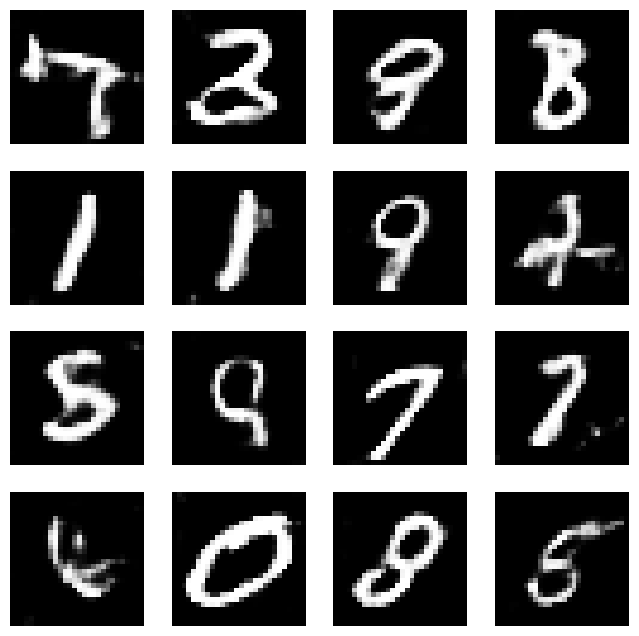

[Epoch   17/30] [Batch   99/938] ---> [D Loss: 0.471628] [G Loss: 0.957108]
[Epoch   17/30] [Batch  199/938] ---> [D Loss: 0.836550] [G Loss: 1.007728]
[Epoch   17/30] [Batch  299/938] ---> [D Loss: 0.487564] [G Loss: 1.164147]
[Epoch   17/30] [Batch  399/938] ---> [D Loss: 0.711610] [G Loss: 1.094980]
[Epoch   17/30] [Batch  499/938] ---> [D Loss: 0.622570] [G Loss: 0.897443]
[Epoch   17/30] [Batch  599/938] ---> [D Loss: 0.556178] [G Loss: 1.073403]
[Epoch   17/30] [Batch  699/938] ---> [D Loss: 0.691455] [G Loss: 0.501968]
[Epoch   17/30] [Batch  799/938] ---> [D Loss: 0.386880] [G Loss: 1.119935]
[Epoch   17/30] [Batch  899/938] ---> [D Loss: 0.528406] [G Loss: 0.951507]


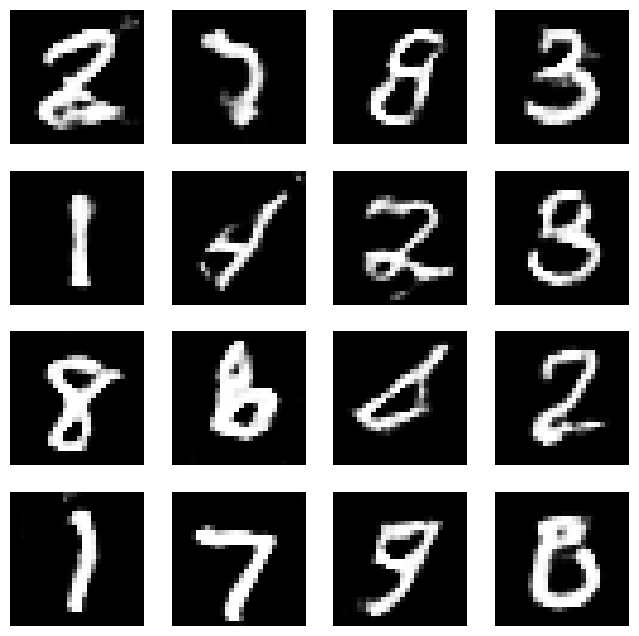

[Epoch   18/30] [Batch   99/938] ---> [D Loss: 0.676341] [G Loss: 1.053904]
[Epoch   18/30] [Batch  199/938] ---> [D Loss: 0.679683] [G Loss: 1.065487]
[Epoch   18/30] [Batch  299/938] ---> [D Loss: 0.626932] [G Loss: 0.722283]
[Epoch   18/30] [Batch  399/938] ---> [D Loss: 0.660307] [G Loss: 0.897729]
[Epoch   18/30] [Batch  499/938] ---> [D Loss: 0.516051] [G Loss: 1.123973]
[Epoch   18/30] [Batch  599/938] ---> [D Loss: 0.649367] [G Loss: 1.080504]
[Epoch   18/30] [Batch  699/938] ---> [D Loss: 0.776912] [G Loss: 0.507695]
[Epoch   18/30] [Batch  799/938] ---> [D Loss: 0.673085] [G Loss: 1.162030]
[Epoch   18/30] [Batch  899/938] ---> [D Loss: 0.588087] [G Loss: 1.205526]


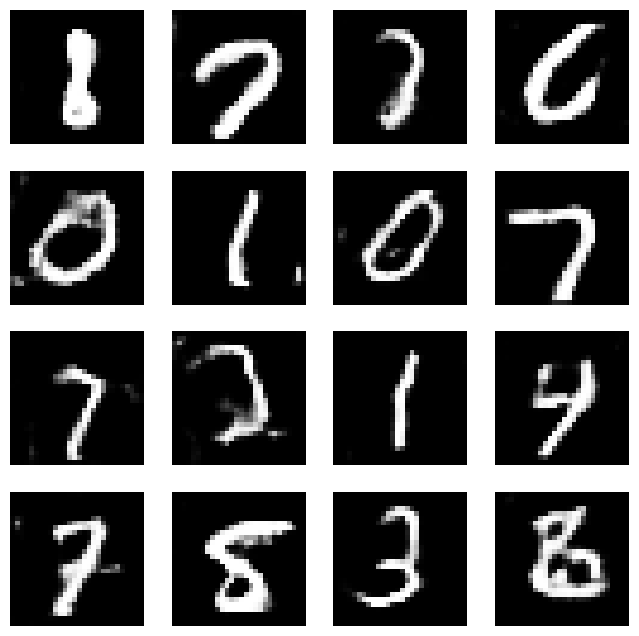

[Epoch   19/30] [Batch   99/938] ---> [D Loss: 0.361424] [G Loss: 0.985988]
[Epoch   19/30] [Batch  199/938] ---> [D Loss: 0.505023] [G Loss: 0.931937]
[Epoch   19/30] [Batch  299/938] ---> [D Loss: 0.598749] [G Loss: 1.000026]
[Epoch   19/30] [Batch  399/938] ---> [D Loss: 0.534005] [G Loss: 0.764138]
[Epoch   19/30] [Batch  499/938] ---> [D Loss: 0.569632] [G Loss: 1.059990]
[Epoch   19/30] [Batch  599/938] ---> [D Loss: 0.501159] [G Loss: 1.236468]
[Epoch   19/30] [Batch  699/938] ---> [D Loss: 0.492494] [G Loss: 0.641178]
[Epoch   19/30] [Batch  799/938] ---> [D Loss: 0.629755] [G Loss: 0.676342]
[Epoch   19/30] [Batch  899/938] ---> [D Loss: 0.636549] [G Loss: 1.085515]


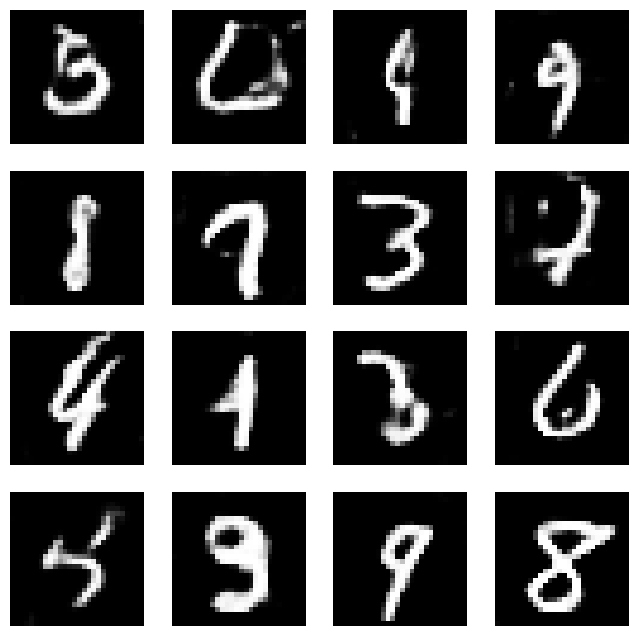

[Epoch   20/30] [Batch   99/938] ---> [D Loss: 0.808148] [G Loss: 0.802632]
[Epoch   20/30] [Batch  199/938] ---> [D Loss: 0.741608] [G Loss: 0.598157]
[Epoch   20/30] [Batch  299/938] ---> [D Loss: 0.596072] [G Loss: 0.592723]
[Epoch   20/30] [Batch  399/938] ---> [D Loss: 0.678025] [G Loss: 1.326416]
[Epoch   20/30] [Batch  499/938] ---> [D Loss: 0.690308] [G Loss: 0.966102]
[Epoch   20/30] [Batch  599/938] ---> [D Loss: 0.741064] [G Loss: 0.836580]
[Epoch   20/30] [Batch  699/938] ---> [D Loss: 0.535125] [G Loss: 1.146101]
[Epoch   20/30] [Batch  799/938] ---> [D Loss: 0.713350] [G Loss: 1.389028]
[Epoch   20/30] [Batch  899/938] ---> [D Loss: 0.500975] [G Loss: 0.959749]


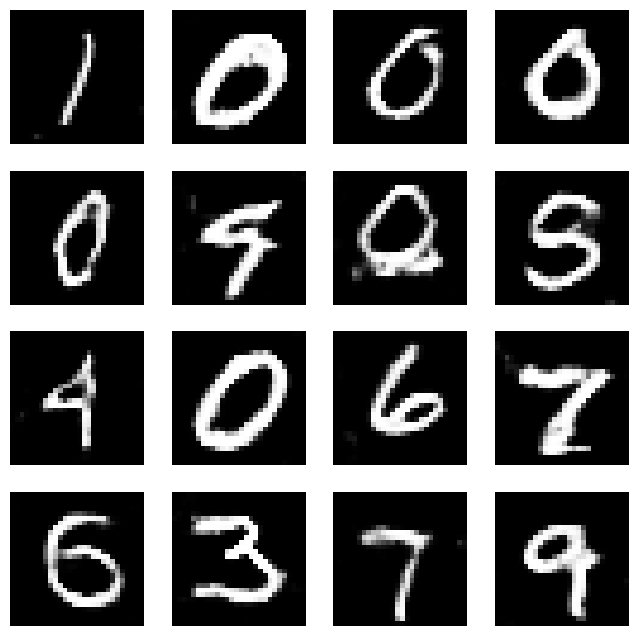

[Epoch   21/30] [Batch   99/938] ---> [D Loss: 0.531529] [G Loss: 0.518675]
[Epoch   21/30] [Batch  199/938] ---> [D Loss: 0.461037] [G Loss: 1.050408]
[Epoch   21/30] [Batch  299/938] ---> [D Loss: 0.683925] [G Loss: 0.688331]
[Epoch   21/30] [Batch  399/938] ---> [D Loss: 0.610897] [G Loss: 1.104478]
[Epoch   21/30] [Batch  499/938] ---> [D Loss: 0.631119] [G Loss: 0.834136]
[Epoch   21/30] [Batch  599/938] ---> [D Loss: 0.500674] [G Loss: 1.370645]
[Epoch   21/30] [Batch  699/938] ---> [D Loss: 0.666388] [G Loss: 0.546962]
[Epoch   21/30] [Batch  799/938] ---> [D Loss: 0.785234] [G Loss: 0.689104]
[Epoch   21/30] [Batch  899/938] ---> [D Loss: 0.530685] [G Loss: 0.859729]


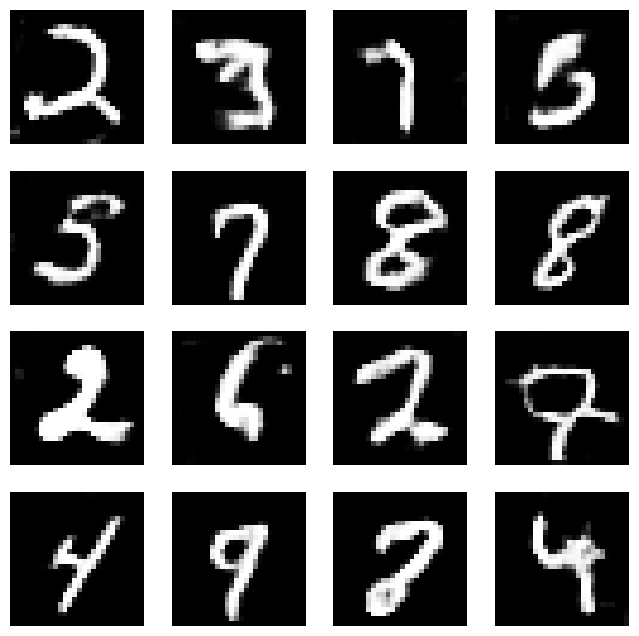

[Epoch   22/30] [Batch   99/938] ---> [D Loss: 0.550868] [G Loss: 0.901294]
[Epoch   22/30] [Batch  199/938] ---> [D Loss: 0.518337] [G Loss: 1.131987]
[Epoch   22/30] [Batch  299/938] ---> [D Loss: 0.598400] [G Loss: 0.871243]
[Epoch   22/30] [Batch  399/938] ---> [D Loss: 0.456554] [G Loss: 1.377189]
[Epoch   22/30] [Batch  499/938] ---> [D Loss: 0.635834] [G Loss: 1.542277]
[Epoch   22/30] [Batch  599/938] ---> [D Loss: 0.796884] [G Loss: 0.761767]
[Epoch   22/30] [Batch  699/938] ---> [D Loss: 0.448267] [G Loss: 0.897877]
[Epoch   22/30] [Batch  799/938] ---> [D Loss: 0.540383] [G Loss: 0.698392]
[Epoch   22/30] [Batch  899/938] ---> [D Loss: 0.709547] [G Loss: 1.168882]


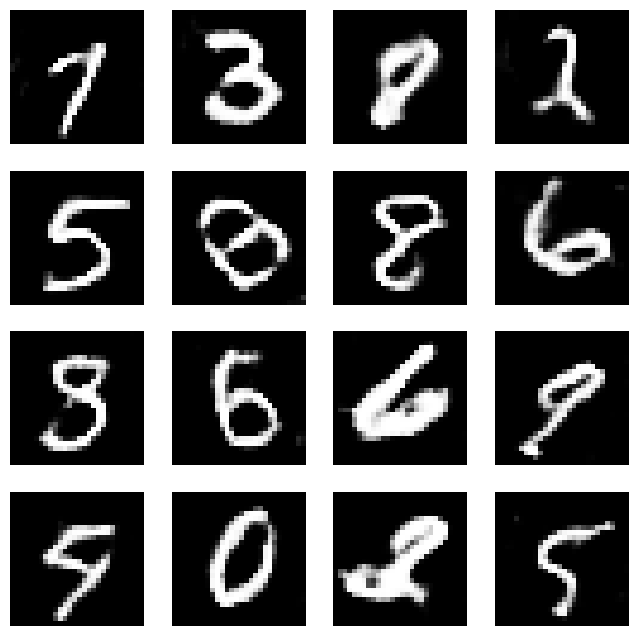

[Epoch   23/30] [Batch   99/938] ---> [D Loss: 0.791958] [G Loss: 0.736817]
[Epoch   23/30] [Batch  199/938] ---> [D Loss: 0.461665] [G Loss: 1.462325]
[Epoch   23/30] [Batch  299/938] ---> [D Loss: 0.527659] [G Loss: 0.964906]
[Epoch   23/30] [Batch  399/938] ---> [D Loss: 0.669353] [G Loss: 0.985898]
[Epoch   23/30] [Batch  499/938] ---> [D Loss: 0.543136] [G Loss: 0.912307]
[Epoch   23/30] [Batch  599/938] ---> [D Loss: 0.617290] [G Loss: 0.784857]
[Epoch   23/30] [Batch  699/938] ---> [D Loss: 0.598816] [G Loss: 1.135258]
[Epoch   23/30] [Batch  799/938] ---> [D Loss: 0.589243] [G Loss: 1.368046]
[Epoch   23/30] [Batch  899/938] ---> [D Loss: 0.433997] [G Loss: 1.291261]


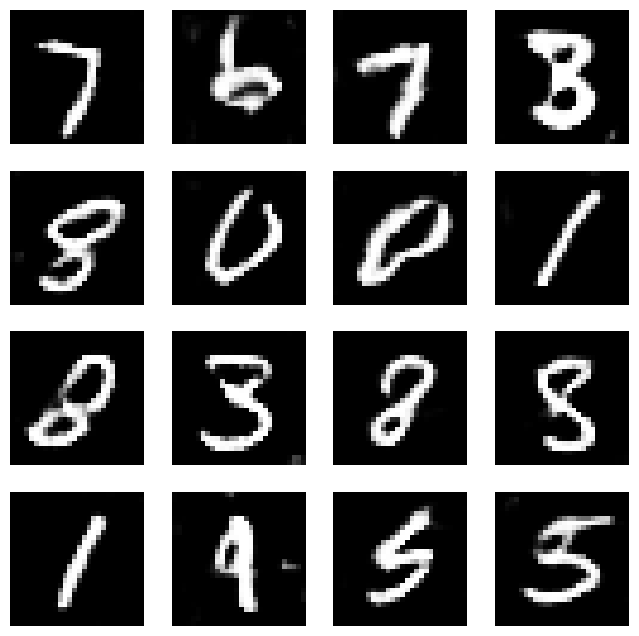

[Epoch   24/30] [Batch   99/938] ---> [D Loss: 0.862018] [G Loss: 1.029770]
[Epoch   24/30] [Batch  199/938] ---> [D Loss: 0.489842] [G Loss: 1.084338]
[Epoch   24/30] [Batch  299/938] ---> [D Loss: 0.425151] [G Loss: 0.980186]
[Epoch   24/30] [Batch  399/938] ---> [D Loss: 0.968158] [G Loss: 1.375329]
[Epoch   24/30] [Batch  499/938] ---> [D Loss: 0.539724] [G Loss: 0.408104]
[Epoch   24/30] [Batch  599/938] ---> [D Loss: 0.583479] [G Loss: 0.760054]
[Epoch   24/30] [Batch  699/938] ---> [D Loss: 0.602391] [G Loss: 1.123679]
[Epoch   24/30] [Batch  799/938] ---> [D Loss: 0.693049] [G Loss: 0.889055]
[Epoch   24/30] [Batch  899/938] ---> [D Loss: 0.433325] [G Loss: 1.063985]


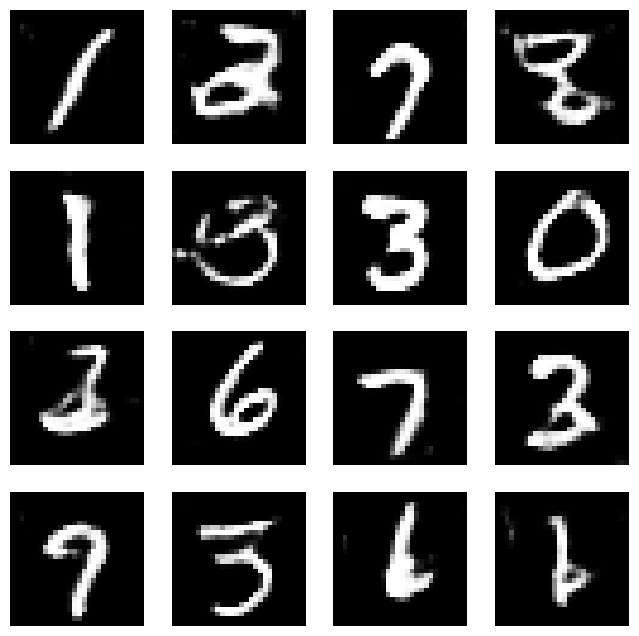

[Epoch   25/30] [Batch   99/938] ---> [D Loss: 0.585233] [G Loss: 0.970371]
[Epoch   25/30] [Batch  199/938] ---> [D Loss: 0.716062] [G Loss: 1.056601]
[Epoch   25/30] [Batch  299/938] ---> [D Loss: 0.450850] [G Loss: 0.721349]
[Epoch   25/30] [Batch  399/938] ---> [D Loss: 0.576424] [G Loss: 1.660959]
[Epoch   25/30] [Batch  499/938] ---> [D Loss: 0.530303] [G Loss: 1.134780]
[Epoch   25/30] [Batch  599/938] ---> [D Loss: 0.768407] [G Loss: 0.775836]
[Epoch   25/30] [Batch  699/938] ---> [D Loss: 0.841007] [G Loss: 1.005184]
[Epoch   25/30] [Batch  799/938] ---> [D Loss: 0.615019] [G Loss: 1.347060]
[Epoch   25/30] [Batch  899/938] ---> [D Loss: 0.884626] [G Loss: 0.867699]


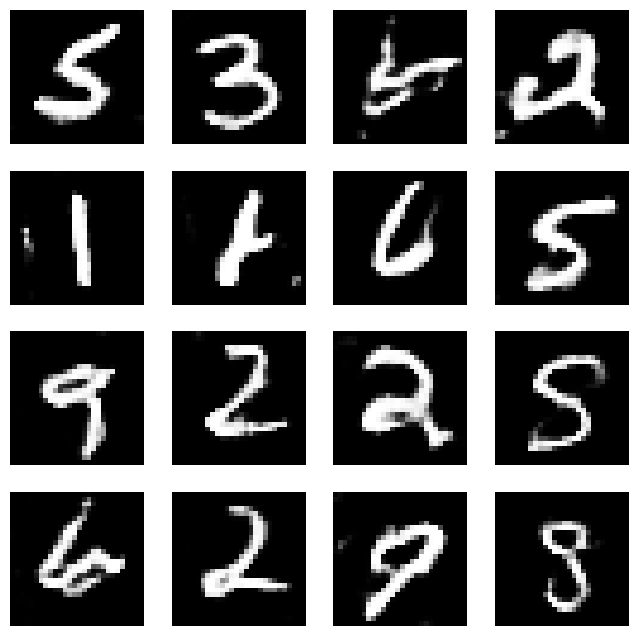

[Epoch   26/30] [Batch   99/938] ---> [D Loss: 0.673701] [G Loss: 0.909263]
[Epoch   26/30] [Batch  199/938] ---> [D Loss: 0.527640] [G Loss: 0.875213]
[Epoch   26/30] [Batch  299/938] ---> [D Loss: 0.533211] [G Loss: 0.784972]
[Epoch   26/30] [Batch  399/938] ---> [D Loss: 0.586318] [G Loss: 0.818542]
[Epoch   26/30] [Batch  499/938] ---> [D Loss: 0.626424] [G Loss: 1.073650]
[Epoch   26/30] [Batch  599/938] ---> [D Loss: 0.588636] [G Loss: 1.218302]
[Epoch   26/30] [Batch  699/938] ---> [D Loss: 0.535059] [G Loss: 0.802920]
[Epoch   26/30] [Batch  799/938] ---> [D Loss: 0.662227] [G Loss: 1.415205]
[Epoch   26/30] [Batch  899/938] ---> [D Loss: 0.682584] [G Loss: 0.857859]


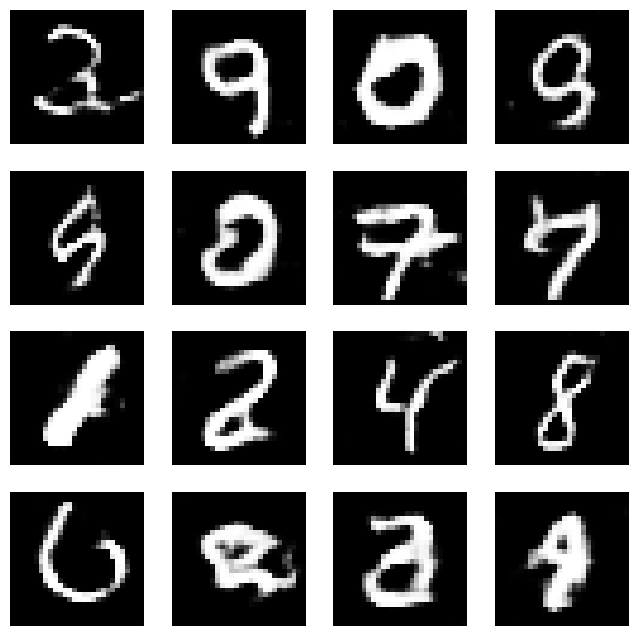

[Epoch   27/30] [Batch   99/938] ---> [D Loss: 0.580785] [G Loss: 0.681757]
[Epoch   27/30] [Batch  199/938] ---> [D Loss: 0.517072] [G Loss: 1.291531]
[Epoch   27/30] [Batch  299/938] ---> [D Loss: 0.458735] [G Loss: 0.852833]
[Epoch   27/30] [Batch  399/938] ---> [D Loss: 0.439136] [G Loss: 0.679875]
[Epoch   27/30] [Batch  499/938] ---> [D Loss: 0.568688] [G Loss: 1.011468]
[Epoch   27/30] [Batch  599/938] ---> [D Loss: 0.530867] [G Loss: 0.792738]
[Epoch   27/30] [Batch  699/938] ---> [D Loss: 0.874049] [G Loss: 1.027314]
[Epoch   27/30] [Batch  799/938] ---> [D Loss: 0.535574] [G Loss: 0.972741]
[Epoch   27/30] [Batch  899/938] ---> [D Loss: 0.479418] [G Loss: 1.708836]


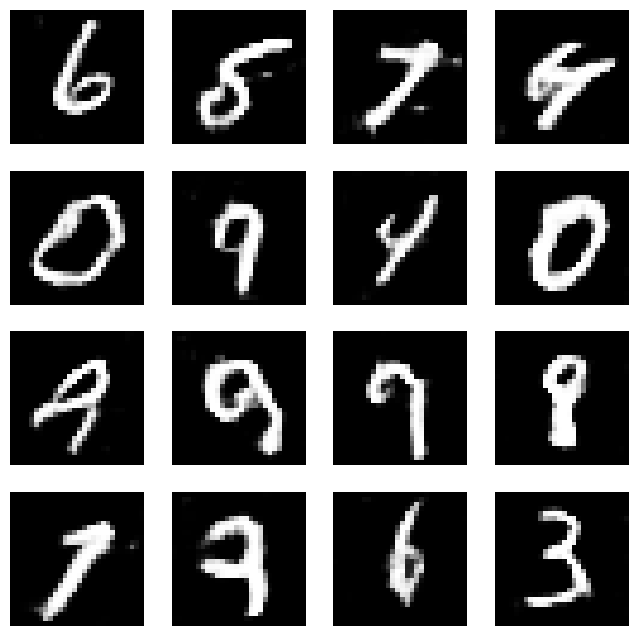

[Epoch   28/30] [Batch   99/938] ---> [D Loss: 0.641459] [G Loss: 0.792085]
[Epoch   28/30] [Batch  199/938] ---> [D Loss: 0.693609] [G Loss: 1.356043]
[Epoch   28/30] [Batch  299/938] ---> [D Loss: 0.438397] [G Loss: 0.541652]
[Epoch   28/30] [Batch  399/938] ---> [D Loss: 0.492367] [G Loss: 1.273192]
[Epoch   28/30] [Batch  499/938] ---> [D Loss: 0.692741] [G Loss: 0.994596]
[Epoch   28/30] [Batch  599/938] ---> [D Loss: 0.781588] [G Loss: 0.631805]
[Epoch   28/30] [Batch  699/938] ---> [D Loss: 0.625319] [G Loss: 1.015278]
[Epoch   28/30] [Batch  799/938] ---> [D Loss: 0.597718] [G Loss: 0.627532]
[Epoch   28/30] [Batch  899/938] ---> [D Loss: 0.876687] [G Loss: 0.906655]


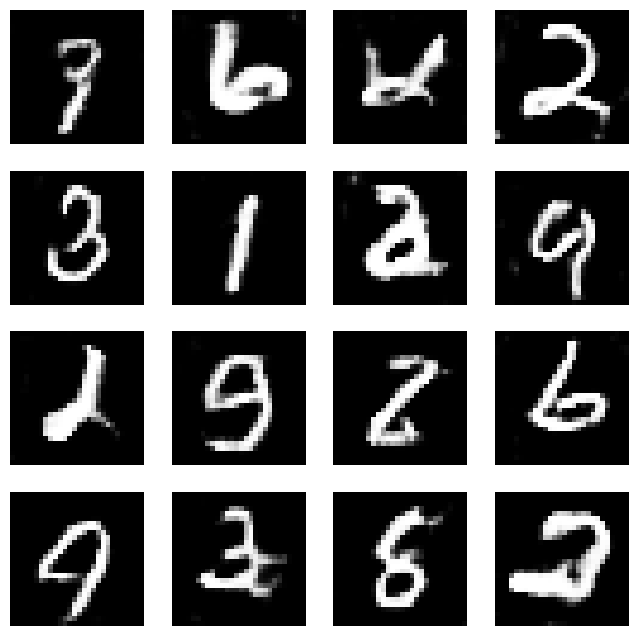

[Epoch   29/30] [Batch   99/938] ---> [D Loss: 0.428048] [G Loss: 1.538338]
[Epoch   29/30] [Batch  199/938] ---> [D Loss: 0.661749] [G Loss: 1.419696]
[Epoch   29/30] [Batch  299/938] ---> [D Loss: 0.637738] [G Loss: 1.243485]
[Epoch   29/30] [Batch  399/938] ---> [D Loss: 0.469998] [G Loss: 0.760034]
[Epoch   29/30] [Batch  499/938] ---> [D Loss: 0.494244] [G Loss: 0.907602]
[Epoch   29/30] [Batch  599/938] ---> [D Loss: 0.492792] [G Loss: 0.842612]
[Epoch   29/30] [Batch  699/938] ---> [D Loss: 0.452088] [G Loss: 0.644414]
[Epoch   29/30] [Batch  799/938] ---> [D Loss: 0.487452] [G Loss: 0.749891]
[Epoch   29/30] [Batch  899/938] ---> [D Loss: 0.679418] [G Loss: 0.603923]


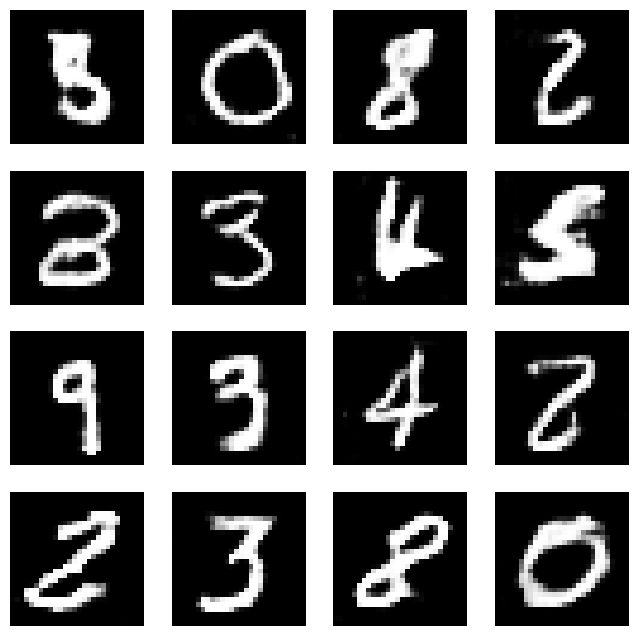

[Epoch   30/30] [Batch   99/938] ---> [D Loss: 0.362019] [G Loss: 0.967093]
[Epoch   30/30] [Batch  199/938] ---> [D Loss: 0.926627] [G Loss: 1.199427]
[Epoch   30/30] [Batch  299/938] ---> [D Loss: 0.640718] [G Loss: 1.004620]
[Epoch   30/30] [Batch  399/938] ---> [D Loss: 0.660068] [G Loss: 1.092851]
[Epoch   30/30] [Batch  499/938] ---> [D Loss: 0.481852] [G Loss: 1.297500]
[Epoch   30/30] [Batch  599/938] ---> [D Loss: 0.411515] [G Loss: 0.713902]
[Epoch   30/30] [Batch  699/938] ---> [D Loss: 0.858383] [G Loss: 0.846342]
[Epoch   30/30] [Batch  799/938] ---> [D Loss: 0.775578] [G Loss: 1.463030]
[Epoch   30/30] [Batch  899/938] ---> [D Loss: 0.683805] [G Loss: 0.596685]


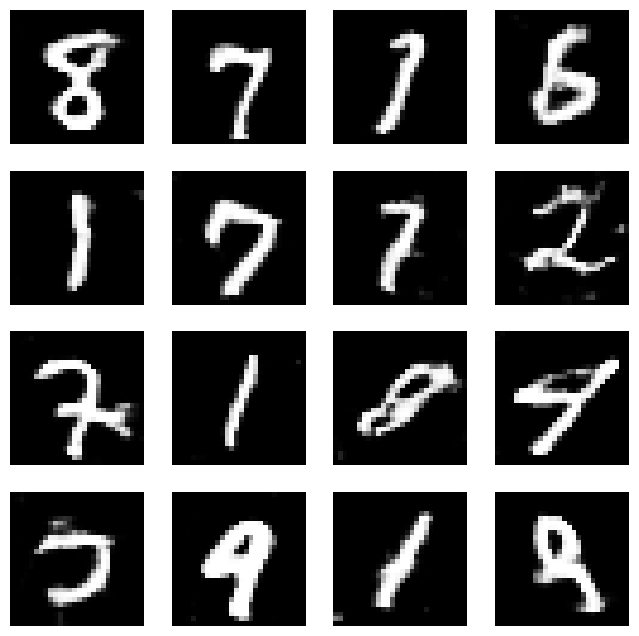

In [16]:
import matplotlib.pyplot as plt
import torchvision
losses = []
images_for_gif = []
for epoch in range(1, epochs+1):
    for i, (images, _) in enumerate(data_loader):

        real_images = images.type(Tensor).to(device)
        real_output = Tensor(images.size(0), 1).fill_(1.0).to(device)
        fake_output = Tensor(images.size(0), 1).fill_(0.0).to(device)

        z = Tensor(np.random.normal(0, 1, (images.shape[0], latent_dim))).to(device)
        generated_images = generator(z)
        
        # Training Discriminator
        optimizer_discriminator.zero_grad()
        discriminator_loss_real = adversarial_loss(discriminator(real_images), real_output)
        discriminator_loss_fake = adversarial_loss(discriminator(generated_images.detach()), fake_output)
        discriminator_loss = (discriminator_loss_real + discriminator_loss_fake) / 2
        discriminator_loss.backward()
        optimizer_discriminator.step()

        # Training Generator
        optimizer_generator.zero_grad()
        optimizer_discriminator.zero_grad()
        
        
        generator_loss = adversarial_loss(discriminator(generated_images), real_output)
        generator_loss.backward()
        optimizer_generator.step()

        

        if (i+1) % 100 == 0:
            print(f"[Epoch {epoch:=4d}/{epochs}] [Batch {i:=4d}/{len(data_loader)}] ---> "
                f"[D Loss: {discriminator_loss.item():.6f}] [G Loss: {generator_loss.item():.6f}]")
        # print percentage of D and G
        
            losses.append((generator_loss.item(), discriminator_loss.item()))
            image_filename = f'{output_dir}/images/{epoch}batch{i}.png'
            save_image(generated_images.data[:25], image_filename, nrow=5, normalize=True)
            # images_for_gif.append(imageio.imread(image_filename))

    fake_images = generated_images.reshape(generated_images.size(0), 1, 28, 28)
        
    plt.figure(figsize=(8, 8))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(fake_images[i].squeeze().cpu().detach().numpy(), cmap='gray')
        plt.axis('off')
    plt.show()
    torchvision.utils.save_image(fake_images, f'./mehrdad/fake_images_with_cnn-{epoch+1}.png', nrow=4, normalize=True)

In [27]:
import imageio

images_for_gif = []
output_dir = './mehrdad'
for i in range(1, 30):
    image_filename = f'./mehrdad/fake_images_with_cnn-{i+1}.png'
    images_for_gif.append(imageio.imread(image_filename))
imageio.mimsave(f"{output_dir}/training_progress1.gif", images_for_gif, fps=5)

C:\Users\COMPUTER SHAHR\AppData\Local\Temp\ipykernel_5840\3215566483.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_for_gif.append(imageio.imread(image_filename))



<div dir="rtl">
<h1></h1>
 <p>   در نهایت عکس هارا به صورت گیف نمایش می دهیم</p>

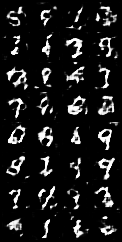

In [28]:
# show the gif  in big size
from IPython.display import Image
Image(filename=f'{output_dir}/training_progress1.gif', width=500, height=500)


<div dir="rtl">
<h1>مدل linear</h1>
 <p>
 در ادامه 
 مدل دیگری تولید می کنیم که فقط از 
 linear
 استفاده می کند 
 که سریع تر هر 
epoch
را طی می کند.   
اما بسیار کند تر پیشرفت می کند تمام قسمت های دیگر به جز مدل شبیه قسمت های قبل است.
 </p>

In [13]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
import imageio

output_dir = './outputjustlinear'
latent_dim = 100
learning_rate = 0.0002
b1 = 0.5
b2 = 0.999
epochs = 200
batch_size = 64

os.makedirs(f'{output_dir}/images', exist_ok=True)

Tensor = torch.FloatTensor
image_shape = (1, 28, 28)

In [14]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, int(np.prod((1, 28, 28)))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *image_shape)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(int(np.prod((1, 28, 28))), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

generator = Generator(latent_dim)
discriminator = Discriminator()

adversarial_loss = torch.nn.BCELoss()
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print (torch.cuda.is_available())
discriminator.to(device)
generator.to(device)

True


Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [15]:
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(b1, b2))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(b1, b2))

In [16]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

data_loader = DataLoader(datasets.MNIST('./data/mnist', train=True, download=True, transform=transform),
                         batch_size=batch_size, shuffle=True)

[Epoch    1/200] [Batch   99/938] ---> [D Loss: 0.527632] [G Loss: 0.640596]
[Epoch    1/200] [Batch  199/938] ---> [D Loss: 0.623953] [G Loss: 0.606438]
[Epoch    1/200] [Batch  299/938] ---> [D Loss: 0.560472] [G Loss: 1.182462]
[Epoch    1/200] [Batch  399/938] ---> [D Loss: 0.691581] [G Loss: 0.403125]
[Epoch    1/200] [Batch  499/938] ---> [D Loss: 0.330326] [G Loss: 1.206167]
[Epoch    1/200] [Batch  599/938] ---> [D Loss: 0.367962] [G Loss: 1.020309]
[Epoch    1/200] [Batch  699/938] ---> [D Loss: 0.410696] [G Loss: 1.343920]
[Epoch    1/200] [Batch  799/938] ---> [D Loss: 0.379087] [G Loss: 1.115617]
[Epoch    1/200] [Batch  899/938] ---> [D Loss: 0.662946] [G Loss: 0.454386]


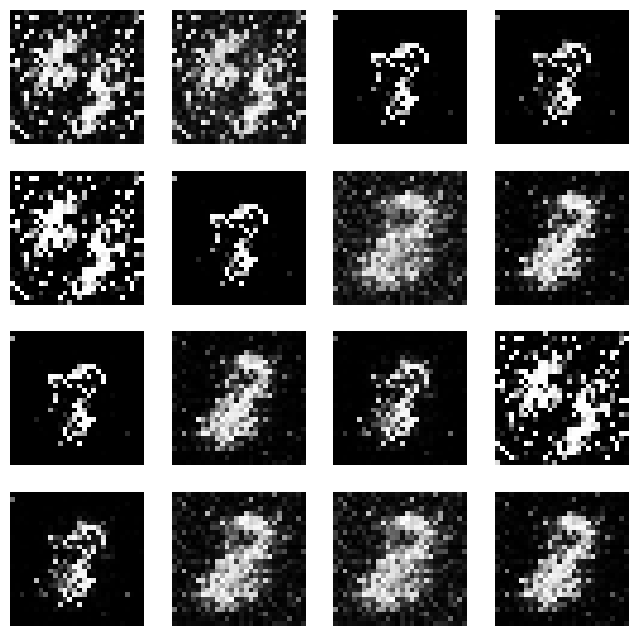

[Epoch    2/200] [Batch   99/938] ---> [D Loss: 0.354416] [G Loss: 1.697535]
[Epoch    2/200] [Batch  199/938] ---> [D Loss: 0.345308] [G Loss: 0.936115]
[Epoch    2/200] [Batch  299/938] ---> [D Loss: 0.337384] [G Loss: 1.296636]
[Epoch    2/200] [Batch  399/938] ---> [D Loss: 0.442813] [G Loss: 2.320181]
[Epoch    2/200] [Batch  499/938] ---> [D Loss: 0.413885] [G Loss: 0.740464]
[Epoch    2/200] [Batch  599/938] ---> [D Loss: 0.444943] [G Loss: 3.051634]
[Epoch    2/200] [Batch  699/938] ---> [D Loss: 0.459710] [G Loss: 0.758219]
[Epoch    2/200] [Batch  799/938] ---> [D Loss: 0.405701] [G Loss: 0.795346]
[Epoch    2/200] [Batch  899/938] ---> [D Loss: 0.447167] [G Loss: 0.628496]
[Epoch    3/200] [Batch   99/938] ---> [D Loss: 0.470162] [G Loss: 2.676528]
[Epoch    3/200] [Batch  199/938] ---> [D Loss: 0.246722] [G Loss: 1.967284]
[Epoch    3/200] [Batch  299/938] ---> [D Loss: 0.657714] [G Loss: 0.355184]
[Epoch    3/200] [Batch  399/938] ---> [D Loss: 0.379742] [G Loss: 1.957133]

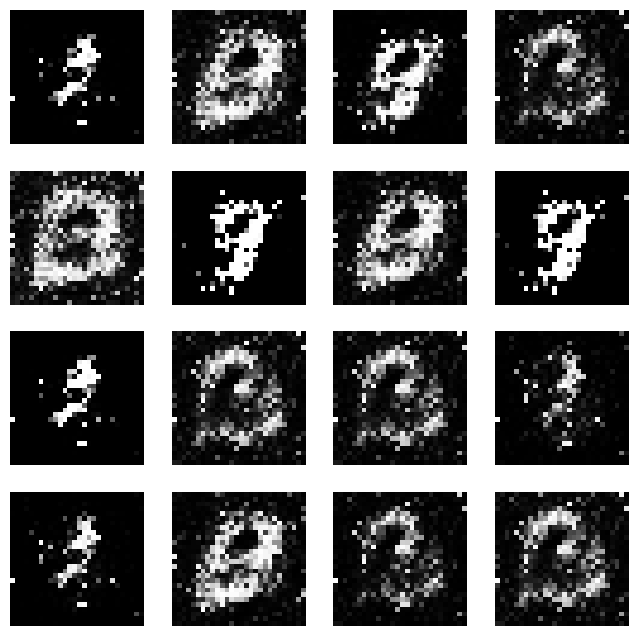

[Epoch    7/200] [Batch   99/938] ---> [D Loss: 0.304599] [G Loss: 1.005642]
[Epoch    7/200] [Batch  199/938] ---> [D Loss: 0.148589] [G Loss: 2.285249]
[Epoch    7/200] [Batch  299/938] ---> [D Loss: 0.339194] [G Loss: 3.561142]
[Epoch    7/200] [Batch  399/938] ---> [D Loss: 0.354676] [G Loss: 0.847175]
[Epoch    7/200] [Batch  499/938] ---> [D Loss: 0.328339] [G Loss: 1.635149]
[Epoch    7/200] [Batch  599/938] ---> [D Loss: 0.165136] [G Loss: 2.678487]
[Epoch    7/200] [Batch  699/938] ---> [D Loss: 0.190573] [G Loss: 1.594279]
[Epoch    7/200] [Batch  799/938] ---> [D Loss: 0.753612] [G Loss: 4.903047]
[Epoch    7/200] [Batch  899/938] ---> [D Loss: 0.527998] [G Loss: 0.536908]
[Epoch    8/200] [Batch   99/938] ---> [D Loss: 0.253868] [G Loss: 1.090942]
[Epoch    8/200] [Batch  199/938] ---> [D Loss: 0.200383] [G Loss: 2.084863]
[Epoch    8/200] [Batch  299/938] ---> [D Loss: 0.271906] [G Loss: 2.382458]
[Epoch    8/200] [Batch  399/938] ---> [D Loss: 0.690425] [G Loss: 4.984506]

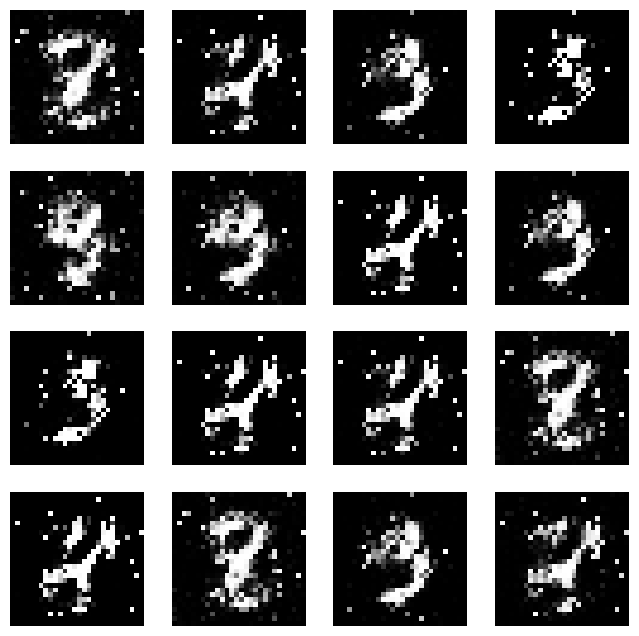

[Epoch   12/200] [Batch   99/938] ---> [D Loss: 0.112787] [G Loss: 3.943076]
[Epoch   12/200] [Batch  199/938] ---> [D Loss: 0.368445] [G Loss: 2.025449]
[Epoch   12/200] [Batch  299/938] ---> [D Loss: 0.492819] [G Loss: 3.657784]
[Epoch   12/200] [Batch  399/938] ---> [D Loss: 0.193576] [G Loss: 2.158730]
[Epoch   12/200] [Batch  499/938] ---> [D Loss: 0.223480] [G Loss: 2.417119]
[Epoch   12/200] [Batch  599/938] ---> [D Loss: 0.226979] [G Loss: 3.773040]
[Epoch   12/200] [Batch  699/938] ---> [D Loss: 0.226794] [G Loss: 2.740932]
[Epoch   12/200] [Batch  799/938] ---> [D Loss: 0.325030] [G Loss: 1.802936]
[Epoch   12/200] [Batch  899/938] ---> [D Loss: 0.270794] [G Loss: 1.674015]
[Epoch   13/200] [Batch   99/938] ---> [D Loss: 0.082194] [G Loss: 2.300751]
[Epoch   13/200] [Batch  199/938] ---> [D Loss: 0.431754] [G Loss: 1.500209]
[Epoch   13/200] [Batch  299/938] ---> [D Loss: 0.265935] [G Loss: 1.293383]
[Epoch   13/200] [Batch  399/938] ---> [D Loss: 0.289456] [G Loss: 1.008279]

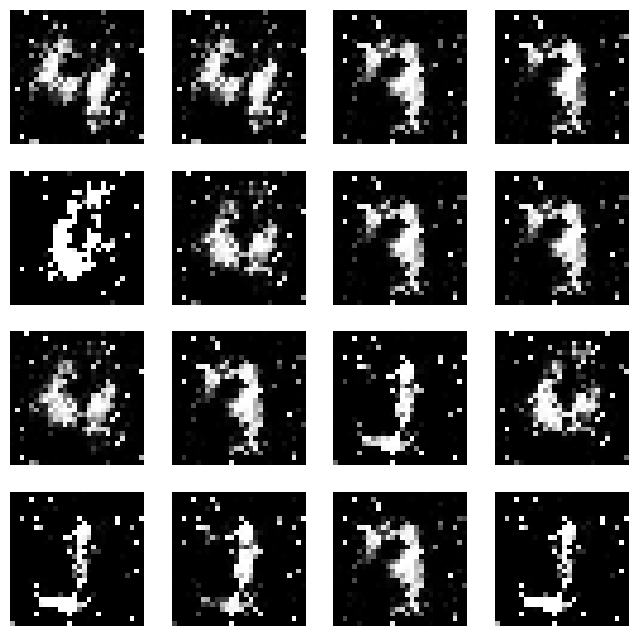

[Epoch   17/200] [Batch   99/938] ---> [D Loss: 0.140147] [G Loss: 2.840720]
[Epoch   17/200] [Batch  199/938] ---> [D Loss: 0.209777] [G Loss: 1.752352]
[Epoch   17/200] [Batch  299/938] ---> [D Loss: 0.172362] [G Loss: 2.345291]
[Epoch   17/200] [Batch  399/938] ---> [D Loss: 0.157643] [G Loss: 2.873673]
[Epoch   17/200] [Batch  499/938] ---> [D Loss: 0.598491] [G Loss: 0.587023]
[Epoch   17/200] [Batch  599/938] ---> [D Loss: 0.159611] [G Loss: 1.832508]
[Epoch   17/200] [Batch  699/938] ---> [D Loss: 0.107293] [G Loss: 2.032355]
[Epoch   17/200] [Batch  799/938] ---> [D Loss: 0.302863] [G Loss: 4.466972]
[Epoch   17/200] [Batch  899/938] ---> [D Loss: 0.293968] [G Loss: 7.500251]
[Epoch   18/200] [Batch   99/938] ---> [D Loss: 0.290082] [G Loss: 1.779086]
[Epoch   18/200] [Batch  199/938] ---> [D Loss: 0.158234] [G Loss: 1.956337]
[Epoch   18/200] [Batch  299/938] ---> [D Loss: 0.230330] [G Loss: 1.970650]
[Epoch   18/200] [Batch  399/938] ---> [D Loss: 0.155932] [G Loss: 3.403658]

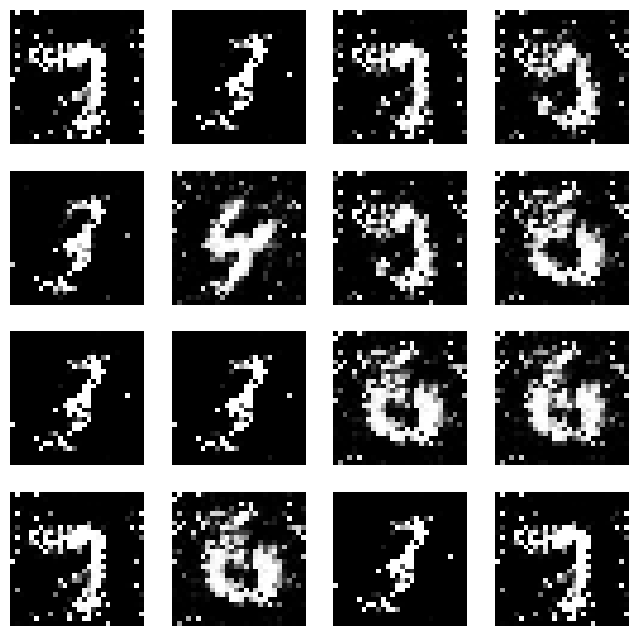

[Epoch   22/200] [Batch   99/938] ---> [D Loss: 0.191324] [G Loss: 2.029084]
[Epoch   22/200] [Batch  199/938] ---> [D Loss: 0.127595] [G Loss: 2.537508]
[Epoch   22/200] [Batch  299/938] ---> [D Loss: 0.188937] [G Loss: 3.533418]
[Epoch   22/200] [Batch  399/938] ---> [D Loss: 0.341254] [G Loss: 1.022654]
[Epoch   22/200] [Batch  499/938] ---> [D Loss: 0.086604] [G Loss: 3.463249]
[Epoch   22/200] [Batch  599/938] ---> [D Loss: 0.170518] [G Loss: 2.595744]
[Epoch   22/200] [Batch  699/938] ---> [D Loss: 0.233088] [G Loss: 1.443537]
[Epoch   22/200] [Batch  799/938] ---> [D Loss: 0.260891] [G Loss: 2.342117]
[Epoch   22/200] [Batch  899/938] ---> [D Loss: 0.216303] [G Loss: 2.584734]
[Epoch   23/200] [Batch   99/938] ---> [D Loss: 0.293941] [G Loss: 5.312965]
[Epoch   23/200] [Batch  199/938] ---> [D Loss: 0.095409] [G Loss: 2.266439]
[Epoch   23/200] [Batch  299/938] ---> [D Loss: 0.073042] [G Loss: 3.244524]
[Epoch   23/200] [Batch  399/938] ---> [D Loss: 0.110780] [G Loss: 3.226994]

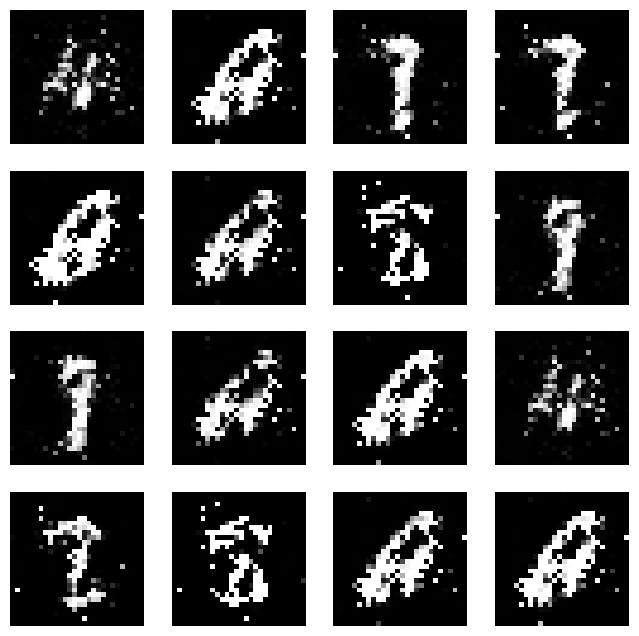

[Epoch   27/200] [Batch   99/938] ---> [D Loss: 0.190969] [G Loss: 1.432917]
[Epoch   27/200] [Batch  199/938] ---> [D Loss: 0.267234] [G Loss: 3.141813]
[Epoch   27/200] [Batch  299/938] ---> [D Loss: 0.137149] [G Loss: 4.204278]
[Epoch   27/200] [Batch  399/938] ---> [D Loss: 0.201926] [G Loss: 2.238364]
[Epoch   27/200] [Batch  499/938] ---> [D Loss: 0.261436] [G Loss: 1.388569]
[Epoch   27/200] [Batch  599/938] ---> [D Loss: 0.154607] [G Loss: 2.207100]
[Epoch   27/200] [Batch  699/938] ---> [D Loss: 0.226877] [G Loss: 5.873567]
[Epoch   27/200] [Batch  799/938] ---> [D Loss: 0.633947] [G Loss: 1.096664]
[Epoch   27/200] [Batch  899/938] ---> [D Loss: 0.191780] [G Loss: 1.990803]
[Epoch   28/200] [Batch   99/938] ---> [D Loss: 0.222551] [G Loss: 1.507404]
[Epoch   28/200] [Batch  199/938] ---> [D Loss: 0.178651] [G Loss: 2.451968]
[Epoch   28/200] [Batch  299/938] ---> [D Loss: 0.090234] [G Loss: 2.683206]
[Epoch   28/200] [Batch  399/938] ---> [D Loss: 0.226299] [G Loss: 1.432297]

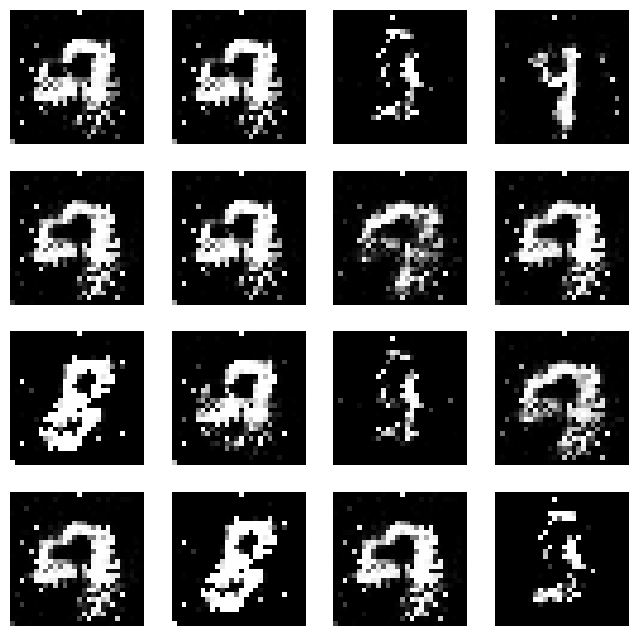

[Epoch   32/200] [Batch   99/938] ---> [D Loss: 0.227871] [G Loss: 2.352441]
[Epoch   32/200] [Batch  199/938] ---> [D Loss: 0.109445] [G Loss: 2.041342]
[Epoch   32/200] [Batch  299/938] ---> [D Loss: 0.403636] [G Loss: 8.274363]
[Epoch   32/200] [Batch  399/938] ---> [D Loss: 0.172944] [G Loss: 4.498697]
[Epoch   32/200] [Batch  499/938] ---> [D Loss: 0.221079] [G Loss: 1.647691]
[Epoch   32/200] [Batch  599/938] ---> [D Loss: 0.123746] [G Loss: 2.543563]
[Epoch   32/200] [Batch  699/938] ---> [D Loss: 0.141673] [G Loss: 2.548805]
[Epoch   32/200] [Batch  799/938] ---> [D Loss: 0.749289] [G Loss: 8.679682]
[Epoch   32/200] [Batch  899/938] ---> [D Loss: 0.190207] [G Loss: 2.572086]
[Epoch   33/200] [Batch   99/938] ---> [D Loss: 0.326058] [G Loss: 1.445099]
[Epoch   33/200] [Batch  199/938] ---> [D Loss: 0.121023] [G Loss: 3.434370]
[Epoch   33/200] [Batch  299/938] ---> [D Loss: 0.138275] [G Loss: 2.300576]
[Epoch   33/200] [Batch  399/938] ---> [D Loss: 0.185420] [G Loss: 2.058530]

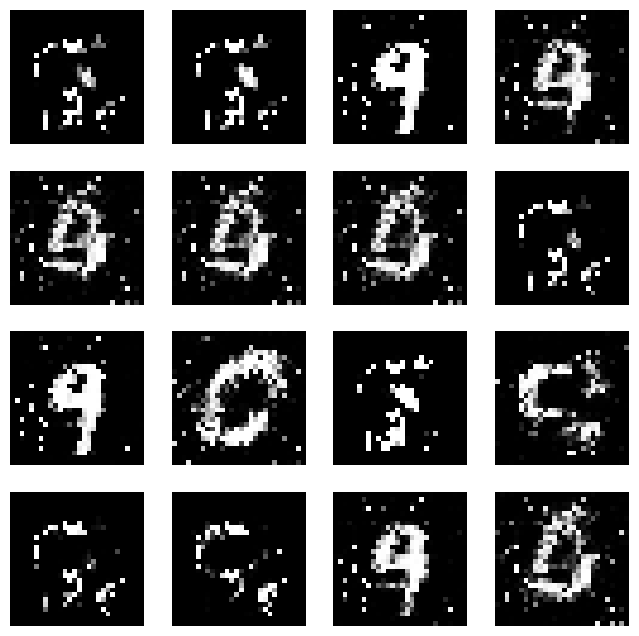

[Epoch   37/200] [Batch   99/938] ---> [D Loss: 0.246179] [G Loss: 3.007230]
[Epoch   37/200] [Batch  199/938] ---> [D Loss: 0.096577] [G Loss: 2.184617]
[Epoch   37/200] [Batch  299/938] ---> [D Loss: 0.145748] [G Loss: 2.895049]
[Epoch   37/200] [Batch  399/938] ---> [D Loss: 0.102863] [G Loss: 2.780294]
[Epoch   37/200] [Batch  499/938] ---> [D Loss: 0.036533] [G Loss: 3.764835]
[Epoch   37/200] [Batch  599/938] ---> [D Loss: 0.254860] [G Loss: 1.881562]
[Epoch   37/200] [Batch  699/938] ---> [D Loss: 0.162815] [G Loss: 2.410928]
[Epoch   37/200] [Batch  799/938] ---> [D Loss: 0.070620] [G Loss: 3.164712]
[Epoch   37/200] [Batch  899/938] ---> [D Loss: 0.126730] [G Loss: 2.571852]
[Epoch   38/200] [Batch   99/938] ---> [D Loss: 0.151886] [G Loss: 2.843873]
[Epoch   38/200] [Batch  199/938] ---> [D Loss: 0.206564] [G Loss: 5.169823]
[Epoch   38/200] [Batch  299/938] ---> [D Loss: 0.157811] [G Loss: 2.300373]
[Epoch   38/200] [Batch  399/938] ---> [D Loss: 0.236166] [G Loss: 1.378432]

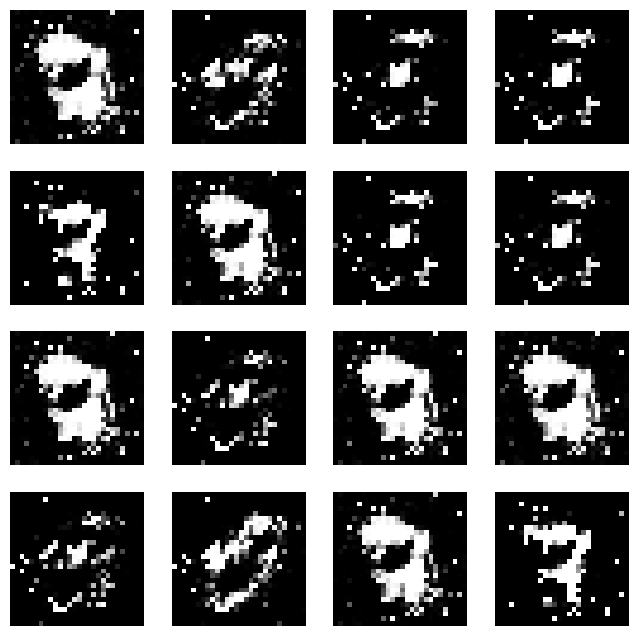

[Epoch   42/200] [Batch   99/938] ---> [D Loss: 0.106118] [G Loss: 2.086573]
[Epoch   42/200] [Batch  199/938] ---> [D Loss: 0.153370] [G Loss: 2.988698]
[Epoch   42/200] [Batch  299/938] ---> [D Loss: 0.104415] [G Loss: 3.096679]
[Epoch   42/200] [Batch  399/938] ---> [D Loss: 0.165559] [G Loss: 3.261781]
[Epoch   42/200] [Batch  499/938] ---> [D Loss: 0.100917] [G Loss: 2.294788]
[Epoch   42/200] [Batch  599/938] ---> [D Loss: 0.182251] [G Loss: 4.441689]
[Epoch   42/200] [Batch  699/938] ---> [D Loss: 0.244356] [G Loss: 1.338499]
[Epoch   42/200] [Batch  799/938] ---> [D Loss: 0.149960] [G Loss: 4.250572]
[Epoch   42/200] [Batch  899/938] ---> [D Loss: 0.199938] [G Loss: 3.069685]
[Epoch   43/200] [Batch   99/938] ---> [D Loss: 0.118576] [G Loss: 2.392484]
[Epoch   43/200] [Batch  199/938] ---> [D Loss: 0.143421] [G Loss: 2.269264]
[Epoch   43/200] [Batch  299/938] ---> [D Loss: 0.158431] [G Loss: 2.771361]
[Epoch   43/200] [Batch  399/938] ---> [D Loss: 0.137815] [G Loss: 2.888558]

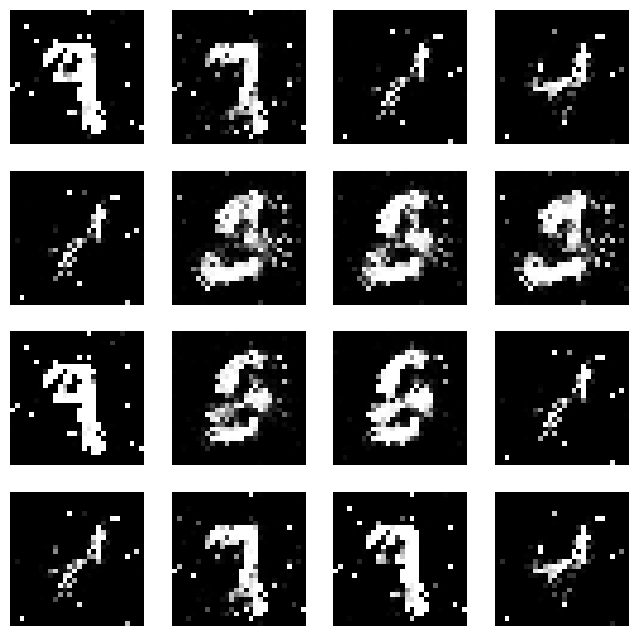

[Epoch   47/200] [Batch   99/938] ---> [D Loss: 0.669514] [G Loss: 8.783347]
[Epoch   47/200] [Batch  199/938] ---> [D Loss: 0.153416] [G Loss: 3.040882]
[Epoch   47/200] [Batch  299/938] ---> [D Loss: 0.131760] [G Loss: 2.308126]
[Epoch   47/200] [Batch  399/938] ---> [D Loss: 0.165873] [G Loss: 2.506266]
[Epoch   47/200] [Batch  499/938] ---> [D Loss: 0.231997] [G Loss: 2.482944]
[Epoch   47/200] [Batch  599/938] ---> [D Loss: 0.196288] [G Loss: 2.398658]
[Epoch   47/200] [Batch  699/938] ---> [D Loss: 0.138987] [G Loss: 3.001565]
[Epoch   47/200] [Batch  799/938] ---> [D Loss: 0.140869] [G Loss: 3.695198]
[Epoch   47/200] [Batch  899/938] ---> [D Loss: 0.078645] [G Loss: 2.748921]
[Epoch   48/200] [Batch   99/938] ---> [D Loss: 0.062972] [G Loss: 2.866029]
[Epoch   48/200] [Batch  199/938] ---> [D Loss: 0.158282] [G Loss: 2.976892]
[Epoch   48/200] [Batch  299/938] ---> [D Loss: 0.111946] [G Loss: 2.739569]
[Epoch   48/200] [Batch  399/938] ---> [D Loss: 0.216480] [G Loss: 3.031086]

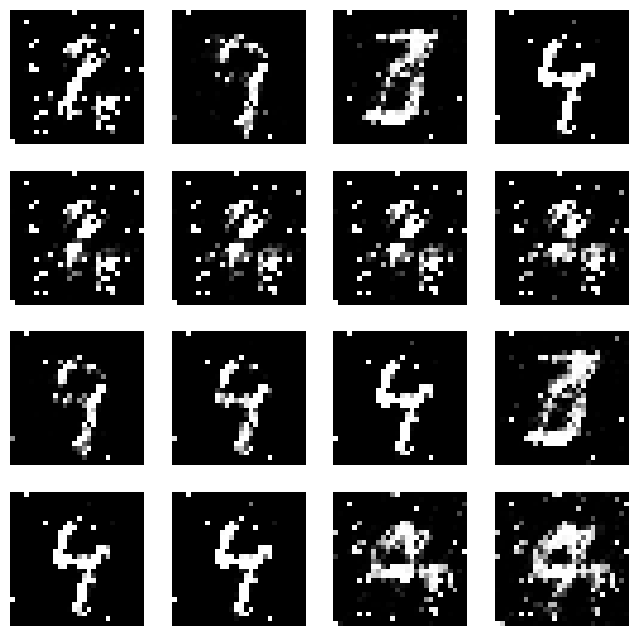

[Epoch   52/200] [Batch   99/938] ---> [D Loss: 0.165972] [G Loss: 7.757481]
[Epoch   52/200] [Batch  199/938] ---> [D Loss: 0.036770] [G Loss: 3.994931]
[Epoch   52/200] [Batch  299/938] ---> [D Loss: 0.020660] [G Loss: 4.715955]
[Epoch   52/200] [Batch  399/938] ---> [D Loss: 0.072319] [G Loss: 3.664506]
[Epoch   52/200] [Batch  499/938] ---> [D Loss: 0.194317] [G Loss: 4.346705]
[Epoch   52/200] [Batch  599/938] ---> [D Loss: 0.220961] [G Loss: 2.643533]
[Epoch   52/200] [Batch  699/938] ---> [D Loss: 0.080210] [G Loss: 3.528964]
[Epoch   52/200] [Batch  799/938] ---> [D Loss: 0.120734] [G Loss: 3.759181]
[Epoch   52/200] [Batch  899/938] ---> [D Loss: 0.245465] [G Loss: 1.601031]
[Epoch   53/200] [Batch   99/938] ---> [D Loss: 0.060117] [G Loss: 2.927813]
[Epoch   53/200] [Batch  199/938] ---> [D Loss: 0.224364] [G Loss: 3.879958]
[Epoch   53/200] [Batch  299/938] ---> [D Loss: 0.122472] [G Loss: 2.589001]
[Epoch   53/200] [Batch  399/938] ---> [D Loss: 0.307642] [G Loss: 6.667791]

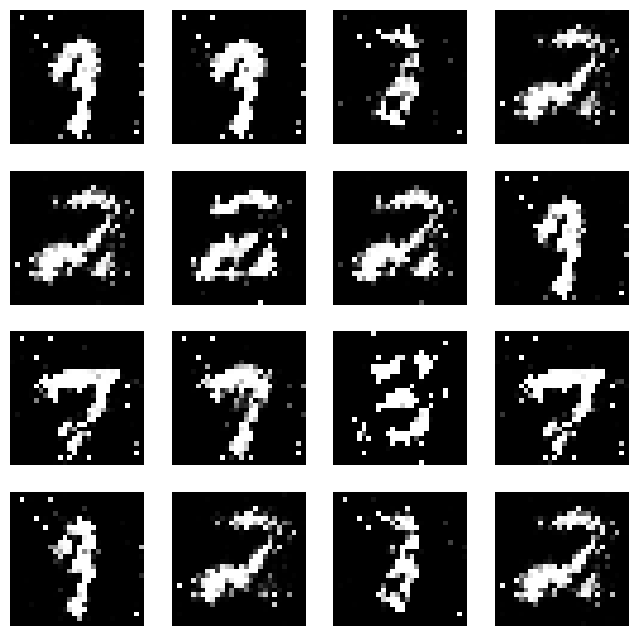

[Epoch   57/200] [Batch   99/938] ---> [D Loss: 0.083892] [G Loss: 2.363421]
[Epoch   57/200] [Batch  199/938] ---> [D Loss: 0.177871] [G Loss: 4.290564]
[Epoch   57/200] [Batch  299/938] ---> [D Loss: 0.193583] [G Loss: 2.683068]
[Epoch   57/200] [Batch  399/938] ---> [D Loss: 0.196815] [G Loss: 1.560580]
[Epoch   57/200] [Batch  499/938] ---> [D Loss: 0.220050] [G Loss: 2.517710]
[Epoch   57/200] [Batch  599/938] ---> [D Loss: 0.159722] [G Loss: 3.332530]
[Epoch   57/200] [Batch  699/938] ---> [D Loss: 0.096485] [G Loss: 3.055364]
[Epoch   57/200] [Batch  799/938] ---> [D Loss: 0.125466] [G Loss: 1.934551]
[Epoch   57/200] [Batch  899/938] ---> [D Loss: 0.103915] [G Loss: 4.472470]
[Epoch   58/200] [Batch   99/938] ---> [D Loss: 0.439467] [G Loss: 0.892674]
[Epoch   58/200] [Batch  199/938] ---> [D Loss: 0.276215] [G Loss: 2.827141]
[Epoch   58/200] [Batch  299/938] ---> [D Loss: 0.113476] [G Loss: 3.227940]
[Epoch   58/200] [Batch  399/938] ---> [D Loss: 0.330362] [G Loss: 7.298334]

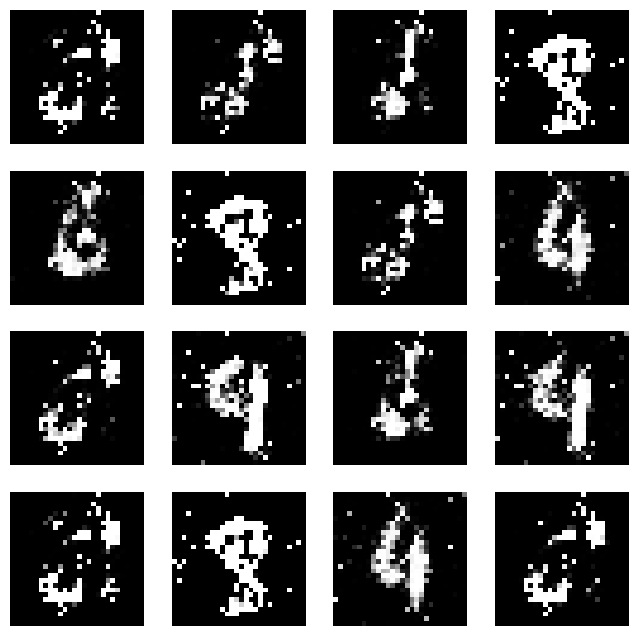

[Epoch   62/200] [Batch   99/938] ---> [D Loss: 0.107290] [G Loss: 2.298132]
[Epoch   62/200] [Batch  199/938] ---> [D Loss: 0.096625] [G Loss: 4.766364]
[Epoch   62/200] [Batch  299/938] ---> [D Loss: 0.363293] [G Loss: 1.297223]
[Epoch   62/200] [Batch  399/938] ---> [D Loss: 0.158727] [G Loss: 2.444520]
[Epoch   62/200] [Batch  499/938] ---> [D Loss: 0.426584] [G Loss: 0.744216]
[Epoch   62/200] [Batch  599/938] ---> [D Loss: 0.201973] [G Loss: 2.230827]
[Epoch   62/200] [Batch  699/938] ---> [D Loss: 0.095490] [G Loss: 3.850395]
[Epoch   62/200] [Batch  799/938] ---> [D Loss: 0.113086] [G Loss: 2.772308]
[Epoch   62/200] [Batch  899/938] ---> [D Loss: 0.134247] [G Loss: 7.434098]
[Epoch   63/200] [Batch   99/938] ---> [D Loss: 0.133413] [G Loss: 3.831320]
[Epoch   63/200] [Batch  199/938] ---> [D Loss: 0.110860] [G Loss: 3.536242]
[Epoch   63/200] [Batch  299/938] ---> [D Loss: 0.088466] [G Loss: 4.264374]
[Epoch   63/200] [Batch  399/938] ---> [D Loss: 0.210999] [G Loss: 4.268722]

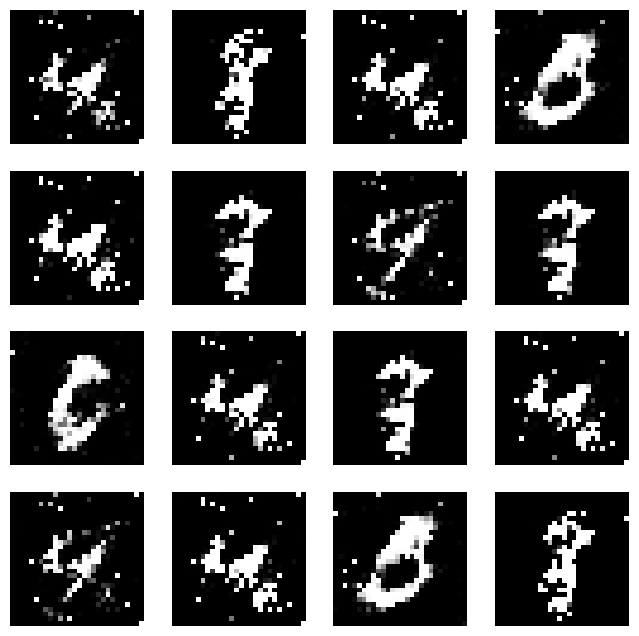

[Epoch   67/200] [Batch   99/938] ---> [D Loss: 0.213562] [G Loss: 3.421961]
[Epoch   67/200] [Batch  199/938] ---> [D Loss: 0.366649] [G Loss: 1.417062]
[Epoch   67/200] [Batch  299/938] ---> [D Loss: 0.174290] [G Loss: 2.624785]
[Epoch   67/200] [Batch  399/938] ---> [D Loss: 0.133297] [G Loss: 1.831287]
[Epoch   67/200] [Batch  499/938] ---> [D Loss: 0.143546] [G Loss: 2.578017]
[Epoch   67/200] [Batch  599/938] ---> [D Loss: 0.133408] [G Loss: 3.916482]
[Epoch   67/200] [Batch  699/938] ---> [D Loss: 0.107978] [G Loss: 2.501430]
[Epoch   67/200] [Batch  799/938] ---> [D Loss: 0.212178] [G Loss: 2.517250]
[Epoch   67/200] [Batch  899/938] ---> [D Loss: 0.192004] [G Loss: 3.267566]
[Epoch   68/200] [Batch   99/938] ---> [D Loss: 0.109495] [G Loss: 3.532000]
[Epoch   68/200] [Batch  199/938] ---> [D Loss: 0.189773] [G Loss: 3.308028]
[Epoch   68/200] [Batch  299/938] ---> [D Loss: 0.160620] [G Loss: 3.135820]
[Epoch   68/200] [Batch  399/938] ---> [D Loss: 0.212363] [G Loss: 3.981230]

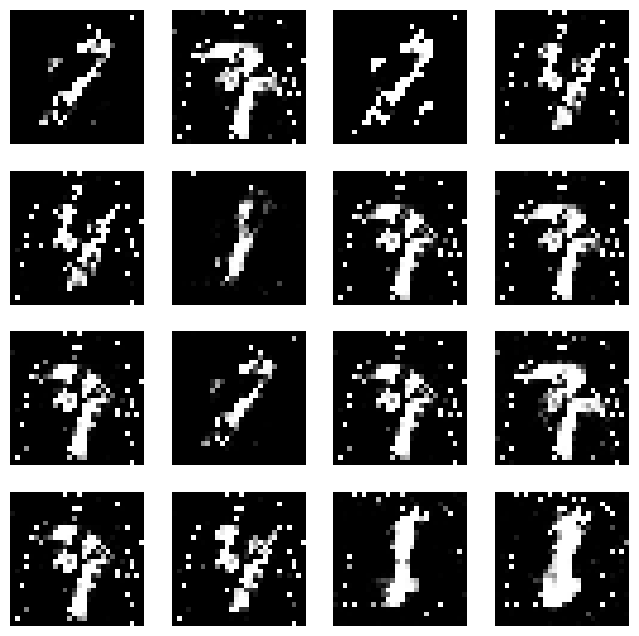

[Epoch   72/200] [Batch   99/938] ---> [D Loss: 0.264216] [G Loss: 1.835443]
[Epoch   72/200] [Batch  199/938] ---> [D Loss: 0.151921] [G Loss: 4.811947]
[Epoch   72/200] [Batch  299/938] ---> [D Loss: 0.068263] [G Loss: 3.408922]
[Epoch   72/200] [Batch  399/938] ---> [D Loss: 0.245796] [G Loss: 3.254959]
[Epoch   72/200] [Batch  499/938] ---> [D Loss: 0.103430] [G Loss: 3.407747]
[Epoch   72/200] [Batch  599/938] ---> [D Loss: 0.190280] [G Loss: 1.933670]
[Epoch   72/200] [Batch  699/938] ---> [D Loss: 0.159045] [G Loss: 2.903639]
[Epoch   72/200] [Batch  799/938] ---> [D Loss: 0.087955] [G Loss: 3.562856]
[Epoch   72/200] [Batch  899/938] ---> [D Loss: 0.052262] [G Loss: 3.140324]
[Epoch   73/200] [Batch   99/938] ---> [D Loss: 0.160927] [G Loss: 5.686049]
[Epoch   73/200] [Batch  199/938] ---> [D Loss: 0.252607] [G Loss: 2.216041]
[Epoch   73/200] [Batch  299/938] ---> [D Loss: 0.039303] [G Loss: 3.831062]
[Epoch   73/200] [Batch  399/938] ---> [D Loss: 0.085112] [G Loss: 3.186285]

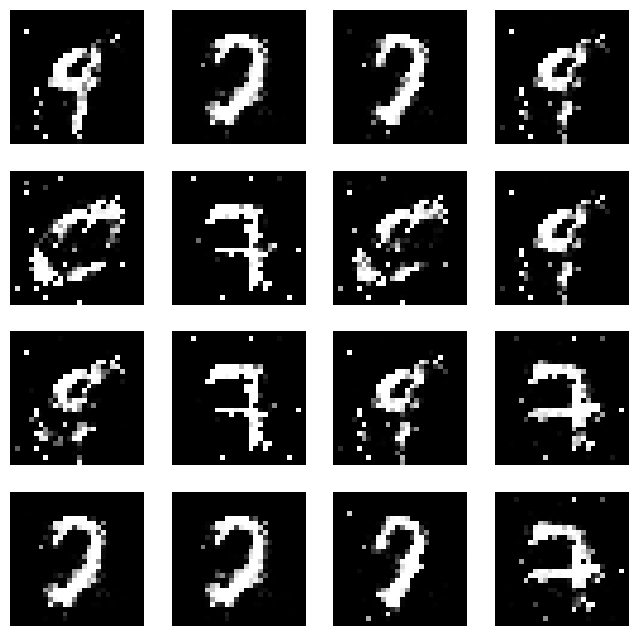

[Epoch   77/200] [Batch   99/938] ---> [D Loss: 0.144170] [G Loss: 2.510806]
[Epoch   77/200] [Batch  199/938] ---> [D Loss: 0.223958] [G Loss: 4.981911]
[Epoch   77/200] [Batch  299/938] ---> [D Loss: 0.131542] [G Loss: 4.321488]
[Epoch   77/200] [Batch  399/938] ---> [D Loss: 0.096444] [G Loss: 3.926346]
[Epoch   77/200] [Batch  499/938] ---> [D Loss: 0.084759] [G Loss: 3.365571]
[Epoch   77/200] [Batch  599/938] ---> [D Loss: 0.175217] [G Loss: 2.632222]
[Epoch   77/200] [Batch  699/938] ---> [D Loss: 0.094260] [G Loss: 2.750839]
[Epoch   77/200] [Batch  799/938] ---> [D Loss: 0.090079] [G Loss: 3.357398]
[Epoch   77/200] [Batch  899/938] ---> [D Loss: 0.334617] [G Loss: 4.081469]
[Epoch   78/200] [Batch   99/938] ---> [D Loss: 0.050719] [G Loss: 3.543886]
[Epoch   78/200] [Batch  199/938] ---> [D Loss: 0.339669] [G Loss: 4.663716]
[Epoch   78/200] [Batch  299/938] ---> [D Loss: 0.201017] [G Loss: 2.940612]
[Epoch   78/200] [Batch  399/938] ---> [D Loss: 0.104855] [G Loss: 2.693417]

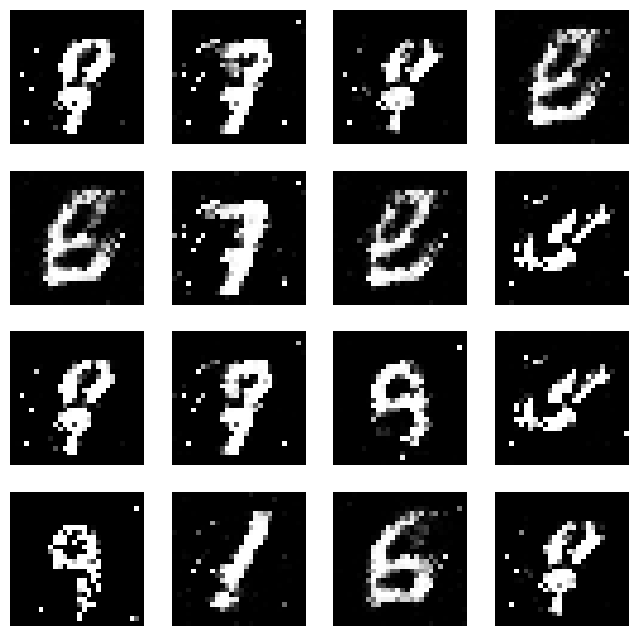

[Epoch   82/200] [Batch   99/938] ---> [D Loss: 0.138903] [G Loss: 2.726988]
[Epoch   82/200] [Batch  199/938] ---> [D Loss: 0.104525] [G Loss: 4.231921]
[Epoch   82/200] [Batch  299/938] ---> [D Loss: 0.211615] [G Loss: 1.963068]
[Epoch   82/200] [Batch  399/938] ---> [D Loss: 0.367872] [G Loss: 1.383838]
[Epoch   82/200] [Batch  499/938] ---> [D Loss: 0.249495] [G Loss: 1.867059]
[Epoch   82/200] [Batch  599/938] ---> [D Loss: 0.174113] [G Loss: 3.307529]
[Epoch   82/200] [Batch  699/938] ---> [D Loss: 0.276566] [G Loss: 2.291740]
[Epoch   82/200] [Batch  799/938] ---> [D Loss: 0.227622] [G Loss: 2.116294]
[Epoch   82/200] [Batch  899/938] ---> [D Loss: 0.117189] [G Loss: 3.369109]
[Epoch   83/200] [Batch   99/938] ---> [D Loss: 0.109435] [G Loss: 2.795841]
[Epoch   83/200] [Batch  199/938] ---> [D Loss: 0.137668] [G Loss: 5.933747]
[Epoch   83/200] [Batch  299/938] ---> [D Loss: 0.083399] [G Loss: 3.293208]
[Epoch   83/200] [Batch  399/938] ---> [D Loss: 0.563896] [G Loss: 8.256056]

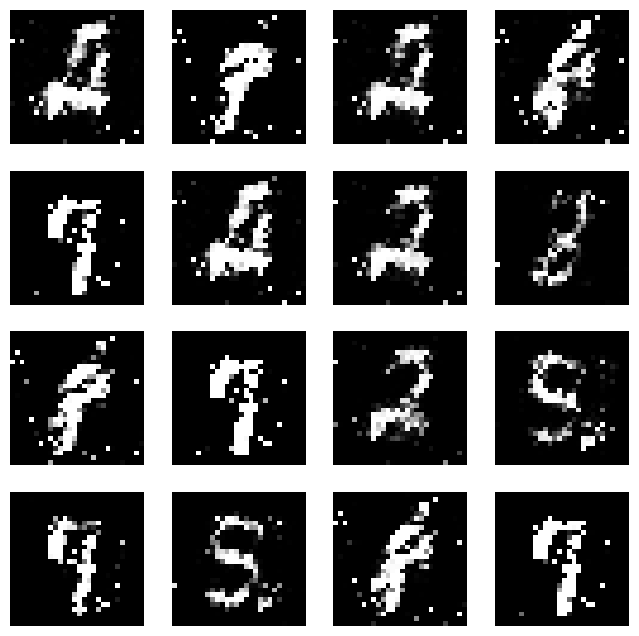

[Epoch   87/200] [Batch   99/938] ---> [D Loss: 0.162451] [G Loss: 4.995811]
[Epoch   87/200] [Batch  199/938] ---> [D Loss: 0.291109] [G Loss: 2.709433]
[Epoch   87/200] [Batch  299/938] ---> [D Loss: 0.131323] [G Loss: 2.418814]
[Epoch   87/200] [Batch  399/938] ---> [D Loss: 0.127478] [G Loss: 2.033700]
[Epoch   87/200] [Batch  499/938] ---> [D Loss: 0.074409] [G Loss: 3.324555]
[Epoch   87/200] [Batch  599/938] ---> [D Loss: 0.102344] [G Loss: 3.589628]
[Epoch   87/200] [Batch  699/938] ---> [D Loss: 0.140693] [G Loss: 3.518207]
[Epoch   87/200] [Batch  799/938] ---> [D Loss: 0.164808] [G Loss: 3.366067]
[Epoch   87/200] [Batch  899/938] ---> [D Loss: 0.128565] [G Loss: 4.008586]
[Epoch   88/200] [Batch   99/938] ---> [D Loss: 0.080057] [G Loss: 3.961322]
[Epoch   88/200] [Batch  199/938] ---> [D Loss: 0.190572] [G Loss: 3.880044]
[Epoch   88/200] [Batch  299/938] ---> [D Loss: 0.135377] [G Loss: 3.305556]
[Epoch   88/200] [Batch  399/938] ---> [D Loss: 0.110767] [G Loss: 2.456621]

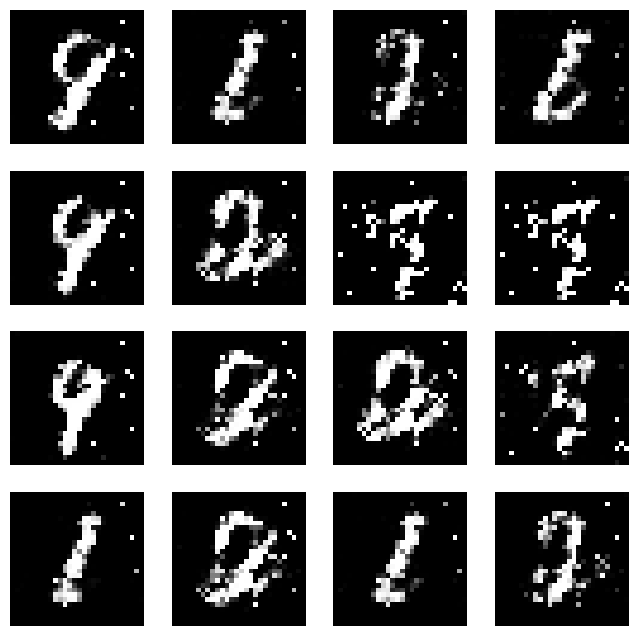

[Epoch   92/200] [Batch   99/938] ---> [D Loss: 0.252795] [G Loss: 1.745269]
[Epoch   92/200] [Batch  199/938] ---> [D Loss: 0.170020] [G Loss: 2.412752]
[Epoch   92/200] [Batch  299/938] ---> [D Loss: 0.163454] [G Loss: 3.777509]
[Epoch   92/200] [Batch  399/938] ---> [D Loss: 0.156084] [G Loss: 2.889238]
[Epoch   92/200] [Batch  499/938] ---> [D Loss: 0.178209] [G Loss: 2.748380]
[Epoch   92/200] [Batch  599/938] ---> [D Loss: 0.108632] [G Loss: 3.425325]
[Epoch   92/200] [Batch  699/938] ---> [D Loss: 0.140004] [G Loss: 2.433033]
[Epoch   92/200] [Batch  799/938] ---> [D Loss: 0.124518] [G Loss: 3.307509]
[Epoch   92/200] [Batch  899/938] ---> [D Loss: 0.237403] [G Loss: 2.427257]
[Epoch   93/200] [Batch   99/938] ---> [D Loss: 0.072001] [G Loss: 2.853830]
[Epoch   93/200] [Batch  199/938] ---> [D Loss: 0.227598] [G Loss: 4.023145]
[Epoch   93/200] [Batch  299/938] ---> [D Loss: 0.135134] [G Loss: 5.837535]
[Epoch   93/200] [Batch  399/938] ---> [D Loss: 0.151020] [G Loss: 3.907249]

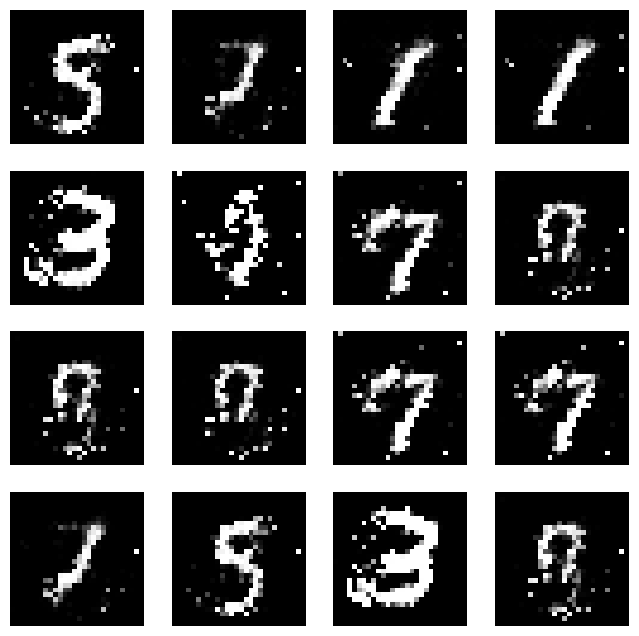

[Epoch   97/200] [Batch   99/938] ---> [D Loss: 0.208229] [G Loss: 5.516642]
[Epoch   97/200] [Batch  199/938] ---> [D Loss: 0.098098] [G Loss: 3.141102]
[Epoch   97/200] [Batch  299/938] ---> [D Loss: 0.084958] [G Loss: 3.091123]
[Epoch   97/200] [Batch  399/938] ---> [D Loss: 0.111919] [G Loss: 2.916484]
[Epoch   97/200] [Batch  499/938] ---> [D Loss: 0.119131] [G Loss: 2.418380]
[Epoch   97/200] [Batch  599/938] ---> [D Loss: 0.152613] [G Loss: 2.142652]
[Epoch   97/200] [Batch  699/938] ---> [D Loss: 0.162839] [G Loss: 1.708756]
[Epoch   97/200] [Batch  799/938] ---> [D Loss: 0.135029] [G Loss: 2.136920]
[Epoch   97/200] [Batch  899/938] ---> [D Loss: 0.127049] [G Loss: 3.607058]
[Epoch   98/200] [Batch   99/938] ---> [D Loss: 0.165677] [G Loss: 2.432438]
[Epoch   98/200] [Batch  199/938] ---> [D Loss: 0.250040] [G Loss: 4.249301]
[Epoch   98/200] [Batch  299/938] ---> [D Loss: 0.088250] [G Loss: 3.360413]
[Epoch   98/200] [Batch  399/938] ---> [D Loss: 0.178931] [G Loss: 3.515273]

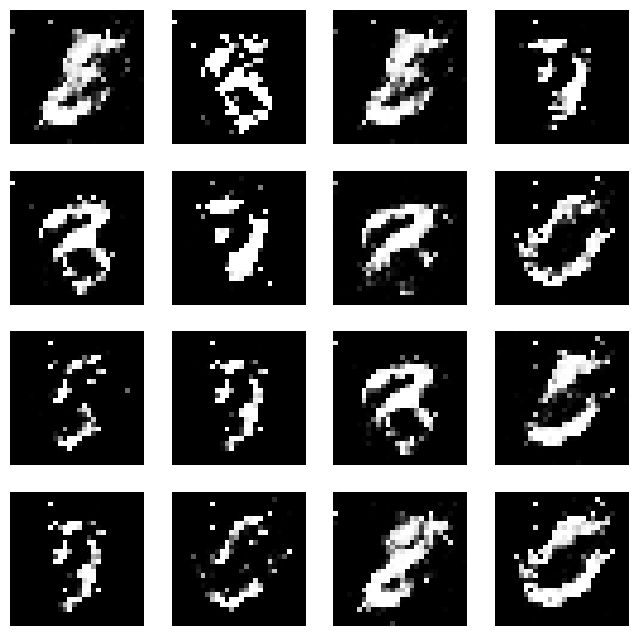

[Epoch  102/200] [Batch   99/938] ---> [D Loss: 0.069321] [G Loss: 3.154530]
[Epoch  102/200] [Batch  199/938] ---> [D Loss: 0.097541] [G Loss: 4.421778]
[Epoch  102/200] [Batch  299/938] ---> [D Loss: 0.091947] [G Loss: 2.676349]
[Epoch  102/200] [Batch  399/938] ---> [D Loss: 0.149246] [G Loss: 2.649803]
[Epoch  102/200] [Batch  499/938] ---> [D Loss: 0.059339] [G Loss: 4.061676]
[Epoch  102/200] [Batch  599/938] ---> [D Loss: 0.208683] [G Loss: 2.495686]
[Epoch  102/200] [Batch  699/938] ---> [D Loss: 0.243973] [G Loss: 4.112858]
[Epoch  102/200] [Batch  799/938] ---> [D Loss: 0.122863] [G Loss: 2.463170]
[Epoch  102/200] [Batch  899/938] ---> [D Loss: 0.115526] [G Loss: 2.478414]
[Epoch  103/200] [Batch   99/938] ---> [D Loss: 0.088655] [G Loss: 5.880123]
[Epoch  103/200] [Batch  199/938] ---> [D Loss: 0.130244] [G Loss: 5.142797]
[Epoch  103/200] [Batch  299/938] ---> [D Loss: 0.034200] [G Loss: 3.529460]
[Epoch  103/200] [Batch  399/938] ---> [D Loss: 0.071953] [G Loss: 3.886580]

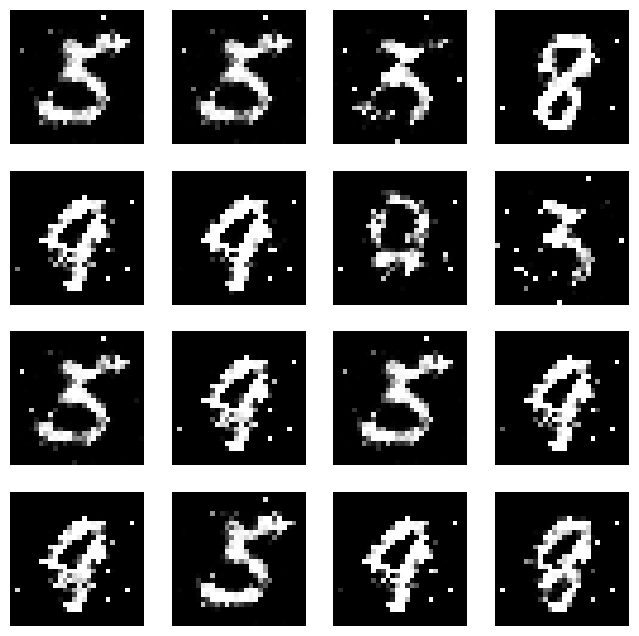

[Epoch  107/200] [Batch   99/938] ---> [D Loss: 0.173929] [G Loss: 3.109873]
[Epoch  107/200] [Batch  199/938] ---> [D Loss: 0.141703] [G Loss: 4.009280]
[Epoch  107/200] [Batch  299/938] ---> [D Loss: 0.230886] [G Loss: 3.903033]
[Epoch  107/200] [Batch  399/938] ---> [D Loss: 0.075945] [G Loss: 4.192426]
[Epoch  107/200] [Batch  499/938] ---> [D Loss: 0.197650] [G Loss: 5.309070]
[Epoch  107/200] [Batch  599/938] ---> [D Loss: 0.153958] [G Loss: 3.917699]
[Epoch  107/200] [Batch  699/938] ---> [D Loss: 0.094461] [G Loss: 2.332531]
[Epoch  107/200] [Batch  799/938] ---> [D Loss: 0.040342] [G Loss: 3.558742]
[Epoch  107/200] [Batch  899/938] ---> [D Loss: 0.130460] [G Loss: 3.145813]
[Epoch  108/200] [Batch   99/938] ---> [D Loss: 0.187363] [G Loss: 3.575210]
[Epoch  108/200] [Batch  199/938] ---> [D Loss: 0.159250] [G Loss: 2.804095]
[Epoch  108/200] [Batch  299/938] ---> [D Loss: 0.261996] [G Loss: 4.218007]
[Epoch  108/200] [Batch  399/938] ---> [D Loss: 0.158397] [G Loss: 1.996181]

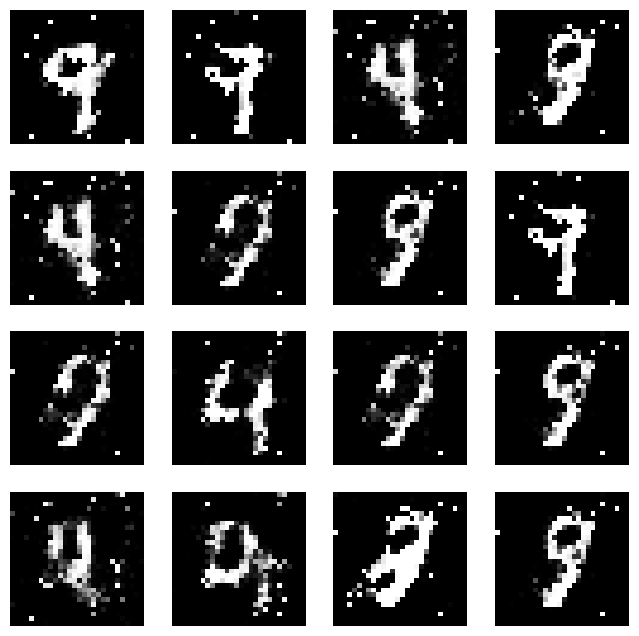

[Epoch  112/200] [Batch   99/938] ---> [D Loss: 0.109545] [G Loss: 3.061626]
[Epoch  112/200] [Batch  199/938] ---> [D Loss: 0.181286] [G Loss: 2.871490]
[Epoch  112/200] [Batch  299/938] ---> [D Loss: 0.087101] [G Loss: 2.940518]
[Epoch  112/200] [Batch  399/938] ---> [D Loss: 0.159189] [G Loss: 3.231008]
[Epoch  112/200] [Batch  499/938] ---> [D Loss: 0.206684] [G Loss: 3.691221]
[Epoch  112/200] [Batch  599/938] ---> [D Loss: 0.095062] [G Loss: 3.719698]
[Epoch  112/200] [Batch  699/938] ---> [D Loss: 0.211259] [G Loss: 2.419069]
[Epoch  112/200] [Batch  799/938] ---> [D Loss: 0.173116] [G Loss: 4.628500]
[Epoch  112/200] [Batch  899/938] ---> [D Loss: 0.081114] [G Loss: 4.397964]
[Epoch  113/200] [Batch   99/938] ---> [D Loss: 0.155023] [G Loss: 3.682585]
[Epoch  113/200] [Batch  199/938] ---> [D Loss: 0.171276] [G Loss: 4.181911]
[Epoch  113/200] [Batch  299/938] ---> [D Loss: 0.115356] [G Loss: 3.780596]
[Epoch  113/200] [Batch  399/938] ---> [D Loss: 0.098488] [G Loss: 3.507372]

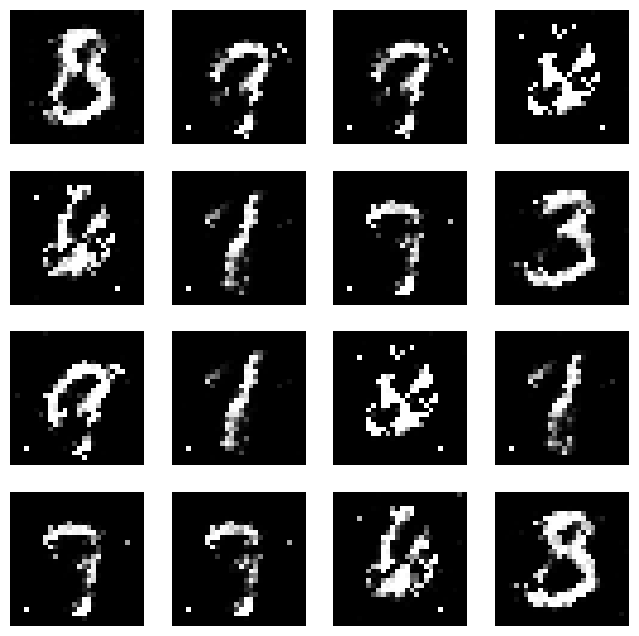

[Epoch  117/200] [Batch   99/938] ---> [D Loss: 0.234660] [G Loss: 1.935434]
[Epoch  117/200] [Batch  199/938] ---> [D Loss: 0.102417] [G Loss: 3.699651]
[Epoch  117/200] [Batch  299/938] ---> [D Loss: 0.116456] [G Loss: 4.017723]
[Epoch  117/200] [Batch  399/938] ---> [D Loss: 0.191763] [G Loss: 4.085808]
[Epoch  117/200] [Batch  499/938] ---> [D Loss: 0.148716] [G Loss: 2.561840]
[Epoch  117/200] [Batch  599/938] ---> [D Loss: 0.121537] [G Loss: 3.662786]
[Epoch  117/200] [Batch  699/938] ---> [D Loss: 0.098391] [G Loss: 4.594730]
[Epoch  117/200] [Batch  799/938] ---> [D Loss: 0.143039] [G Loss: 3.554164]
[Epoch  117/200] [Batch  899/938] ---> [D Loss: 0.224592] [G Loss: 1.956124]
[Epoch  118/200] [Batch   99/938] ---> [D Loss: 0.145162] [G Loss: 3.184145]
[Epoch  118/200] [Batch  199/938] ---> [D Loss: 0.099858] [G Loss: 3.556997]
[Epoch  118/200] [Batch  299/938] ---> [D Loss: 0.107084] [G Loss: 5.624107]
[Epoch  118/200] [Batch  399/938] ---> [D Loss: 0.090420] [G Loss: 3.316288]

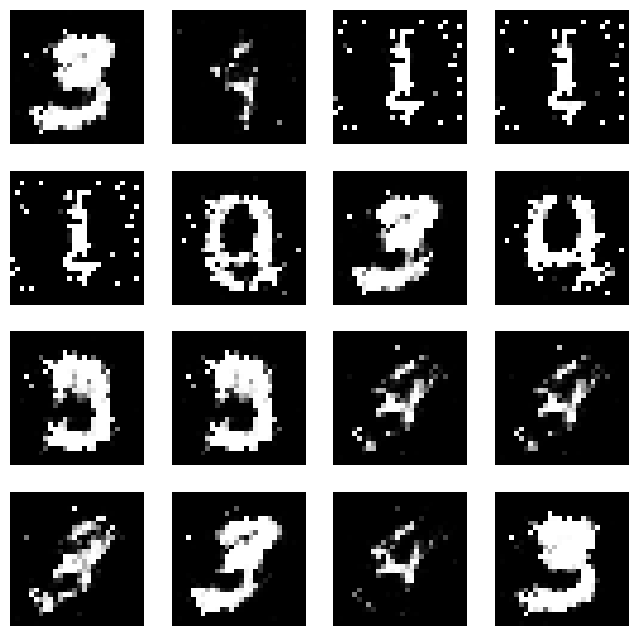

[Epoch  122/200] [Batch   99/938] ---> [D Loss: 0.066871] [G Loss: 3.419596]
[Epoch  122/200] [Batch  199/938] ---> [D Loss: 0.118583] [G Loss: 3.274031]
[Epoch  122/200] [Batch  299/938] ---> [D Loss: 0.100252] [G Loss: 5.291050]
[Epoch  122/200] [Batch  399/938] ---> [D Loss: 0.403816] [G Loss: 8.190826]
[Epoch  122/200] [Batch  499/938] ---> [D Loss: 0.151147] [G Loss: 3.765382]
[Epoch  122/200] [Batch  599/938] ---> [D Loss: 0.147638] [G Loss: 4.134366]
[Epoch  122/200] [Batch  699/938] ---> [D Loss: 0.090900] [G Loss: 3.175068]
[Epoch  122/200] [Batch  799/938] ---> [D Loss: 0.054585] [G Loss: 3.929669]
[Epoch  122/200] [Batch  899/938] ---> [D Loss: 0.128044] [G Loss: 4.273916]
[Epoch  123/200] [Batch   99/938] ---> [D Loss: 0.048993] [G Loss: 4.278946]
[Epoch  123/200] [Batch  199/938] ---> [D Loss: 0.099685] [G Loss: 2.471350]
[Epoch  123/200] [Batch  299/938] ---> [D Loss: 0.220282] [G Loss: 2.935331]
[Epoch  123/200] [Batch  399/938] ---> [D Loss: 0.093906] [G Loss: 3.466511]

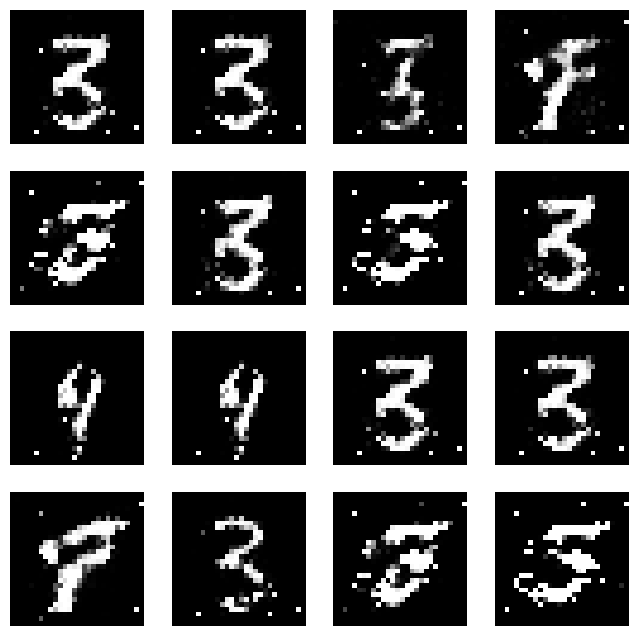

[Epoch  127/200] [Batch   99/938] ---> [D Loss: 0.255695] [G Loss: 4.206176]
[Epoch  127/200] [Batch  199/938] ---> [D Loss: 0.136796] [G Loss: 4.088263]
[Epoch  127/200] [Batch  299/938] ---> [D Loss: 0.120843] [G Loss: 2.687698]
[Epoch  127/200] [Batch  399/938] ---> [D Loss: 0.108859] [G Loss: 2.614004]
[Epoch  127/200] [Batch  499/938] ---> [D Loss: 0.191119] [G Loss: 2.177006]
[Epoch  127/200] [Batch  599/938] ---> [D Loss: 0.113526] [G Loss: 4.147679]
[Epoch  127/200] [Batch  699/938] ---> [D Loss: 0.166000] [G Loss: 4.377176]
[Epoch  127/200] [Batch  799/938] ---> [D Loss: 0.178610] [G Loss: 4.555472]
[Epoch  127/200] [Batch  899/938] ---> [D Loss: 0.064074] [G Loss: 4.493082]
[Epoch  128/200] [Batch   99/938] ---> [D Loss: 0.023153] [G Loss: 4.012881]
[Epoch  128/200] [Batch  199/938] ---> [D Loss: 0.092012] [G Loss: 5.606712]
[Epoch  128/200] [Batch  299/938] ---> [D Loss: 0.031139] [G Loss: 4.865921]
[Epoch  128/200] [Batch  399/938] ---> [D Loss: 0.080718] [G Loss: 3.060333]

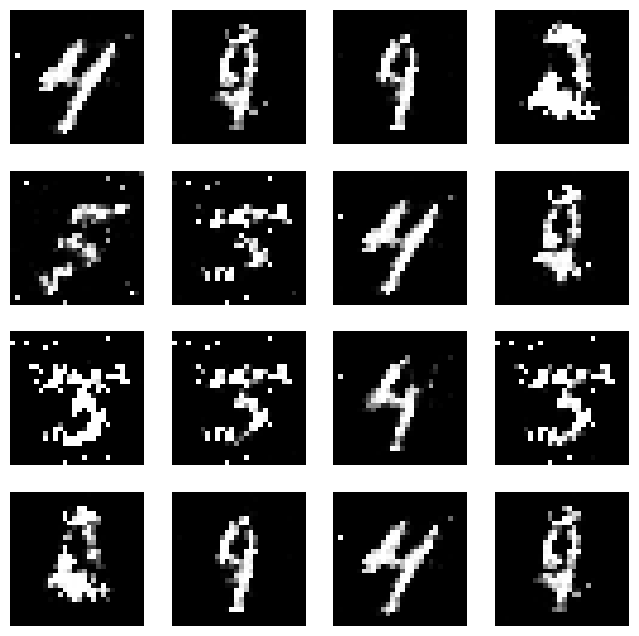

[Epoch  132/200] [Batch   99/938] ---> [D Loss: 0.221646] [G Loss: 1.877340]
[Epoch  132/200] [Batch  199/938] ---> [D Loss: 0.457864] [G Loss: 1.241287]
[Epoch  132/200] [Batch  299/938] ---> [D Loss: 0.197365] [G Loss: 3.663077]
[Epoch  132/200] [Batch  399/938] ---> [D Loss: 0.066006] [G Loss: 3.038431]
[Epoch  132/200] [Batch  499/938] ---> [D Loss: 0.124058] [G Loss: 3.993874]
[Epoch  132/200] [Batch  599/938] ---> [D Loss: 0.256214] [G Loss: 1.676028]
[Epoch  132/200] [Batch  699/938] ---> [D Loss: 0.068032] [G Loss: 3.374606]
[Epoch  132/200] [Batch  799/938] ---> [D Loss: 0.211593] [G Loss: 3.895439]
[Epoch  132/200] [Batch  899/938] ---> [D Loss: 0.255465] [G Loss: 1.677702]
[Epoch  133/200] [Batch   99/938] ---> [D Loss: 0.176604] [G Loss: 3.282381]
[Epoch  133/200] [Batch  199/938] ---> [D Loss: 0.152708] [G Loss: 3.531197]
[Epoch  133/200] [Batch  299/938] ---> [D Loss: 0.082001] [G Loss: 2.681244]
[Epoch  133/200] [Batch  399/938] ---> [D Loss: 0.115061] [G Loss: 4.160419]

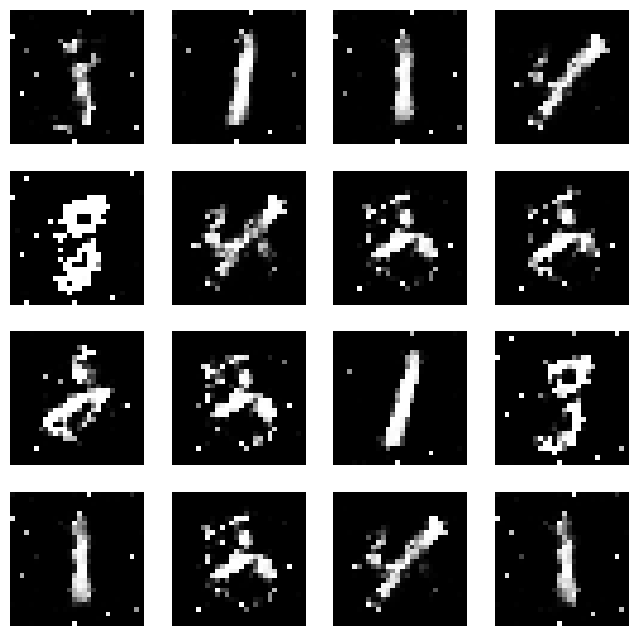

[Epoch  137/200] [Batch   99/938] ---> [D Loss: 0.199290] [G Loss: 4.238145]
[Epoch  137/200] [Batch  199/938] ---> [D Loss: 0.069251] [G Loss: 3.755469]
[Epoch  137/200] [Batch  299/938] ---> [D Loss: 0.111039] [G Loss: 3.368453]
[Epoch  137/200] [Batch  399/938] ---> [D Loss: 0.110566] [G Loss: 2.691548]
[Epoch  137/200] [Batch  499/938] ---> [D Loss: 0.185066] [G Loss: 4.142439]
[Epoch  137/200] [Batch  599/938] ---> [D Loss: 0.049542] [G Loss: 3.838105]
[Epoch  137/200] [Batch  699/938] ---> [D Loss: 0.261681] [G Loss: 4.186748]
[Epoch  137/200] [Batch  799/938] ---> [D Loss: 0.202239] [G Loss: 1.954443]
[Epoch  137/200] [Batch  899/938] ---> [D Loss: 0.131316] [G Loss: 2.915965]
[Epoch  138/200] [Batch   99/938] ---> [D Loss: 0.177654] [G Loss: 4.232786]
[Epoch  138/200] [Batch  199/938] ---> [D Loss: 0.162487] [G Loss: 3.418258]
[Epoch  138/200] [Batch  299/938] ---> [D Loss: 0.181733] [G Loss: 3.383426]
[Epoch  138/200] [Batch  399/938] ---> [D Loss: 0.159791] [G Loss: 1.983624]

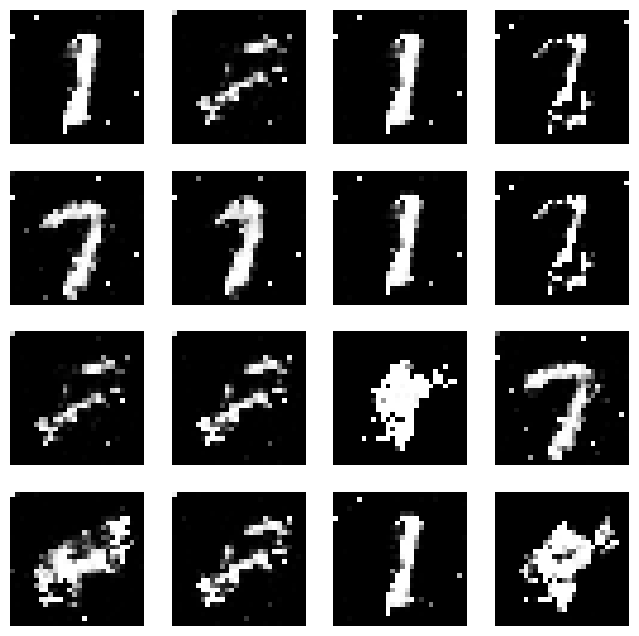

[Epoch  142/200] [Batch   99/938] ---> [D Loss: 0.088117] [G Loss: 2.393239]
[Epoch  142/200] [Batch  199/938] ---> [D Loss: 0.183362] [G Loss: 4.224006]
[Epoch  142/200] [Batch  299/938] ---> [D Loss: 0.142781] [G Loss: 4.415160]
[Epoch  142/200] [Batch  399/938] ---> [D Loss: 0.088117] [G Loss: 2.812271]
[Epoch  142/200] [Batch  499/938] ---> [D Loss: 0.114046] [G Loss: 3.236154]
[Epoch  142/200] [Batch  599/938] ---> [D Loss: 0.129180] [G Loss: 2.231965]
[Epoch  142/200] [Batch  699/938] ---> [D Loss: 0.068614] [G Loss: 2.883929]
[Epoch  142/200] [Batch  799/938] ---> [D Loss: 0.156137] [G Loss: 3.155838]
[Epoch  142/200] [Batch  899/938] ---> [D Loss: 0.061836] [G Loss: 3.487109]
[Epoch  143/200] [Batch   99/938] ---> [D Loss: 0.196715] [G Loss: 1.774425]
[Epoch  143/200] [Batch  199/938] ---> [D Loss: 0.096826] [G Loss: 3.554605]
[Epoch  143/200] [Batch  299/938] ---> [D Loss: 0.112569] [G Loss: 3.576529]
[Epoch  143/200] [Batch  399/938] ---> [D Loss: 0.139825] [G Loss: 2.479788]

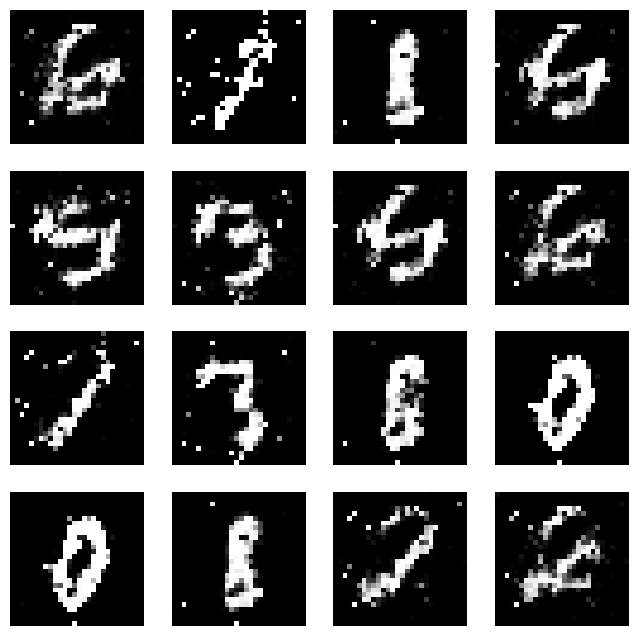

[Epoch  147/200] [Batch   99/938] ---> [D Loss: 0.082669] [G Loss: 3.122523]
[Epoch  147/200] [Batch  199/938] ---> [D Loss: 0.063919] [G Loss: 3.620945]
[Epoch  147/200] [Batch  299/938] ---> [D Loss: 0.055838] [G Loss: 4.278687]
[Epoch  147/200] [Batch  399/938] ---> [D Loss: 0.133243] [G Loss: 3.654692]
[Epoch  147/200] [Batch  499/938] ---> [D Loss: 0.198281] [G Loss: 3.573992]
[Epoch  147/200] [Batch  599/938] ---> [D Loss: 0.144046] [G Loss: 3.407990]
[Epoch  147/200] [Batch  699/938] ---> [D Loss: 0.195753] [G Loss: 5.359936]
[Epoch  147/200] [Batch  799/938] ---> [D Loss: 0.257651] [G Loss: 2.497928]
[Epoch  147/200] [Batch  899/938] ---> [D Loss: 0.177210] [G Loss: 3.146487]
[Epoch  148/200] [Batch   99/938] ---> [D Loss: 0.124358] [G Loss: 3.810188]
[Epoch  148/200] [Batch  199/938] ---> [D Loss: 0.137732] [G Loss: 3.948031]
[Epoch  148/200] [Batch  299/938] ---> [D Loss: 0.201260] [G Loss: 2.633141]
[Epoch  148/200] [Batch  399/938] ---> [D Loss: 0.179341] [G Loss: 2.563296]

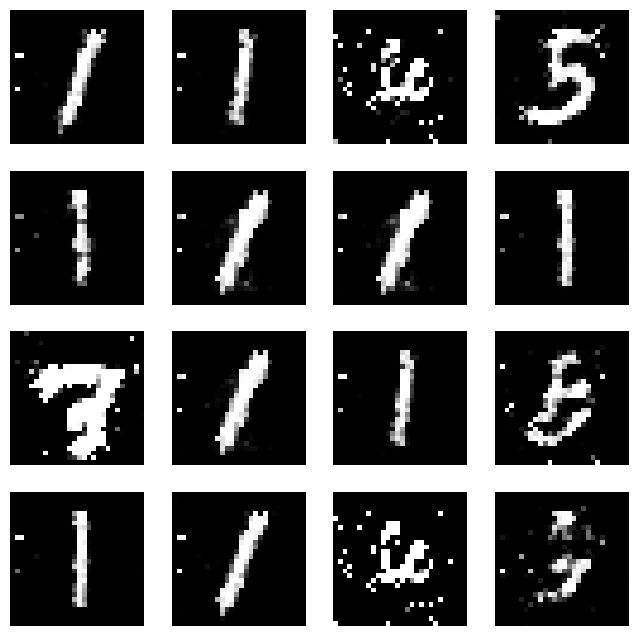

[Epoch  152/200] [Batch   99/938] ---> [D Loss: 0.308159] [G Loss: 2.417783]
[Epoch  152/200] [Batch  199/938] ---> [D Loss: 0.221429] [G Loss: 2.437835]
[Epoch  152/200] [Batch  299/938] ---> [D Loss: 0.139832] [G Loss: 2.797011]
[Epoch  152/200] [Batch  399/938] ---> [D Loss: 0.216052] [G Loss: 3.998090]
[Epoch  152/200] [Batch  499/938] ---> [D Loss: 0.180097] [G Loss: 3.408952]
[Epoch  152/200] [Batch  599/938] ---> [D Loss: 0.150916] [G Loss: 2.426336]
[Epoch  152/200] [Batch  699/938] ---> [D Loss: 0.184847] [G Loss: 3.374378]
[Epoch  152/200] [Batch  799/938] ---> [D Loss: 0.148323] [G Loss: 2.482606]
[Epoch  152/200] [Batch  899/938] ---> [D Loss: 0.191925] [G Loss: 3.091283]
[Epoch  153/200] [Batch   99/938] ---> [D Loss: 0.170500] [G Loss: 3.525885]
[Epoch  153/200] [Batch  199/938] ---> [D Loss: 0.159265] [G Loss: 2.916930]
[Epoch  153/200] [Batch  299/938] ---> [D Loss: 0.151890] [G Loss: 4.703630]
[Epoch  153/200] [Batch  399/938] ---> [D Loss: 0.191693] [G Loss: 3.119766]

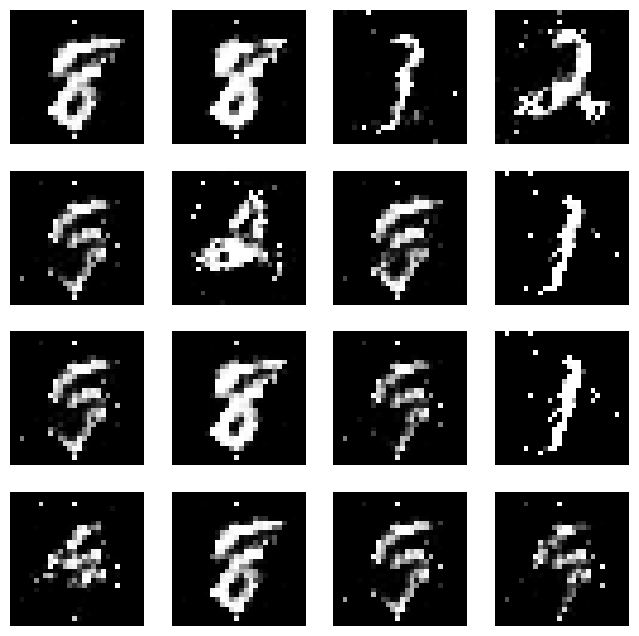

[Epoch  157/200] [Batch   99/938] ---> [D Loss: 0.198473] [G Loss: 1.780317]
[Epoch  157/200] [Batch  199/938] ---> [D Loss: 0.174499] [G Loss: 3.859962]
[Epoch  157/200] [Batch  299/938] ---> [D Loss: 0.184747] [G Loss: 4.612908]
[Epoch  157/200] [Batch  399/938] ---> [D Loss: 0.133315] [G Loss: 3.281801]
[Epoch  157/200] [Batch  499/938] ---> [D Loss: 0.079183] [G Loss: 3.321876]
[Epoch  157/200] [Batch  599/938] ---> [D Loss: 0.155774] [G Loss: 1.915281]
[Epoch  157/200] [Batch  699/938] ---> [D Loss: 0.095661] [G Loss: 4.218140]
[Epoch  157/200] [Batch  799/938] ---> [D Loss: 0.095567] [G Loss: 3.196451]
[Epoch  157/200] [Batch  899/938] ---> [D Loss: 0.128947] [G Loss: 2.862447]
[Epoch  158/200] [Batch   99/938] ---> [D Loss: 0.133552] [G Loss: 2.239124]
[Epoch  158/200] [Batch  199/938] ---> [D Loss: 0.166352] [G Loss: 4.575329]
[Epoch  158/200] [Batch  299/938] ---> [D Loss: 0.095889] [G Loss: 3.574425]
[Epoch  158/200] [Batch  399/938] ---> [D Loss: 0.173459] [G Loss: 3.355574]

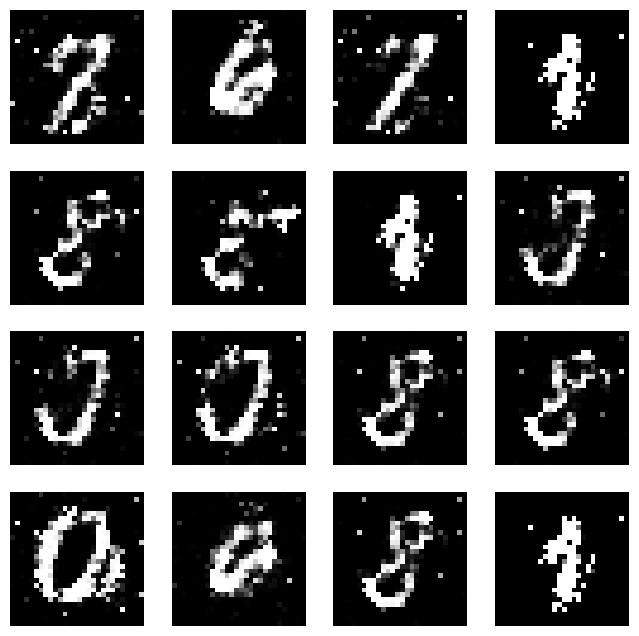

[Epoch  162/200] [Batch   99/938] ---> [D Loss: 0.106193] [G Loss: 3.435076]
[Epoch  162/200] [Batch  199/938] ---> [D Loss: 0.072609] [G Loss: 3.163410]
[Epoch  162/200] [Batch  299/938] ---> [D Loss: 0.057311] [G Loss: 3.351120]
[Epoch  162/200] [Batch  399/938] ---> [D Loss: 0.064775] [G Loss: 3.254530]
[Epoch  162/200] [Batch  499/938] ---> [D Loss: 0.184745] [G Loss: 4.052169]
[Epoch  162/200] [Batch  599/938] ---> [D Loss: 0.257624] [G Loss: 3.078021]
[Epoch  162/200] [Batch  699/938] ---> [D Loss: 0.172280] [G Loss: 2.766178]
[Epoch  162/200] [Batch  799/938] ---> [D Loss: 0.176183] [G Loss: 3.293405]
[Epoch  162/200] [Batch  899/938] ---> [D Loss: 0.307592] [G Loss: 1.637675]
[Epoch  163/200] [Batch   99/938] ---> [D Loss: 0.234865] [G Loss: 2.678060]
[Epoch  163/200] [Batch  199/938] ---> [D Loss: 0.275276] [G Loss: 4.013168]
[Epoch  163/200] [Batch  299/938] ---> [D Loss: 0.135581] [G Loss: 2.827816]
[Epoch  163/200] [Batch  399/938] ---> [D Loss: 0.106383] [G Loss: 3.052900]

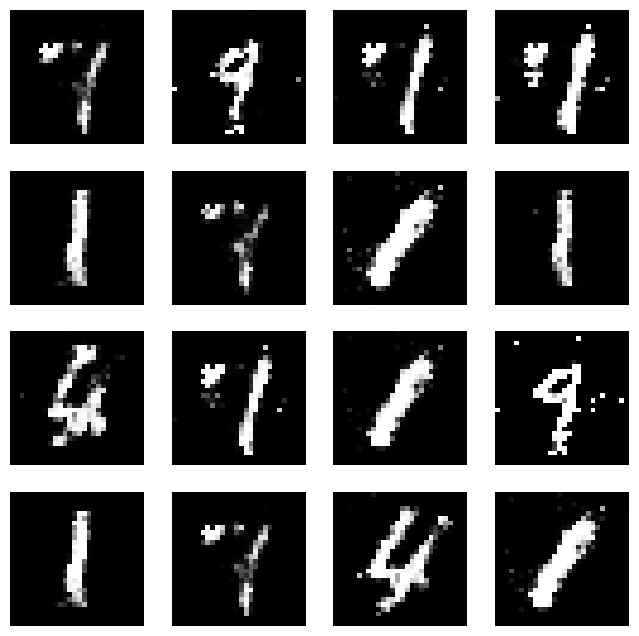

[Epoch  167/200] [Batch   99/938] ---> [D Loss: 0.320297] [G Loss: 5.336617]
[Epoch  167/200] [Batch  199/938] ---> [D Loss: 0.180359] [G Loss: 3.181314]
[Epoch  167/200] [Batch  299/938] ---> [D Loss: 0.136176] [G Loss: 3.466950]
[Epoch  167/200] [Batch  399/938] ---> [D Loss: 0.209675] [G Loss: 2.615701]
[Epoch  167/200] [Batch  499/938] ---> [D Loss: 0.190938] [G Loss: 2.625660]
[Epoch  167/200] [Batch  599/938] ---> [D Loss: 0.096657] [G Loss: 2.653638]
[Epoch  167/200] [Batch  699/938] ---> [D Loss: 0.281497] [G Loss: 3.916977]
[Epoch  167/200] [Batch  799/938] ---> [D Loss: 0.154468] [G Loss: 3.261147]
[Epoch  167/200] [Batch  899/938] ---> [D Loss: 0.108728] [G Loss: 2.502615]
[Epoch  168/200] [Batch   99/938] ---> [D Loss: 0.127899] [G Loss: 2.964717]
[Epoch  168/200] [Batch  199/938] ---> [D Loss: 0.124682] [G Loss: 3.126526]
[Epoch  168/200] [Batch  299/938] ---> [D Loss: 0.143593] [G Loss: 2.115714]
[Epoch  168/200] [Batch  399/938] ---> [D Loss: 0.311146] [G Loss: 5.058848]

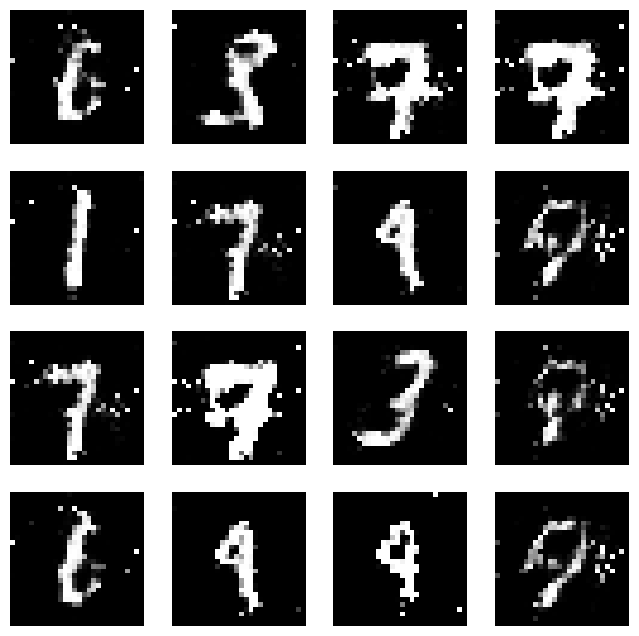

[Epoch  172/200] [Batch   99/938] ---> [D Loss: 0.127784] [G Loss: 3.127967]
[Epoch  172/200] [Batch  199/938] ---> [D Loss: 0.215845] [G Loss: 2.499136]
[Epoch  172/200] [Batch  299/938] ---> [D Loss: 0.223071] [G Loss: 4.549769]
[Epoch  172/200] [Batch  399/938] ---> [D Loss: 0.215379] [G Loss: 4.892337]
[Epoch  172/200] [Batch  499/938] ---> [D Loss: 0.260573] [G Loss: 3.182943]
[Epoch  172/200] [Batch  599/938] ---> [D Loss: 0.193684] [G Loss: 3.020278]
[Epoch  172/200] [Batch  699/938] ---> [D Loss: 0.162730] [G Loss: 2.622212]
[Epoch  172/200] [Batch  799/938] ---> [D Loss: 0.129197] [G Loss: 3.593737]
[Epoch  172/200] [Batch  899/938] ---> [D Loss: 0.051236] [G Loss: 3.906059]
[Epoch  173/200] [Batch   99/938] ---> [D Loss: 0.098987] [G Loss: 4.201804]
[Epoch  173/200] [Batch  199/938] ---> [D Loss: 0.117726] [G Loss: 3.923281]
[Epoch  173/200] [Batch  299/938] ---> [D Loss: 0.159628] [G Loss: 5.215131]
[Epoch  173/200] [Batch  399/938] ---> [D Loss: 0.195988] [G Loss: 5.033882]

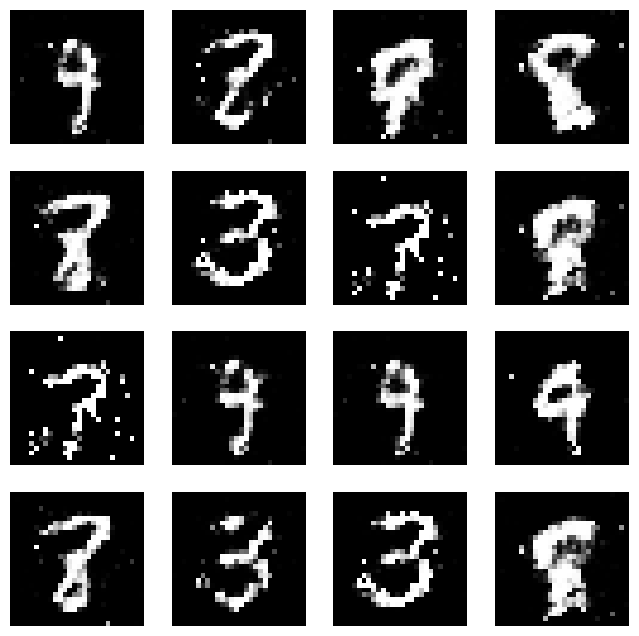

[Epoch  177/200] [Batch   99/938] ---> [D Loss: 0.123399] [G Loss: 3.544792]
[Epoch  177/200] [Batch  199/938] ---> [D Loss: 0.164557] [G Loss: 2.069107]
[Epoch  177/200] [Batch  299/938] ---> [D Loss: 0.104281] [G Loss: 2.775407]
[Epoch  177/200] [Batch  399/938] ---> [D Loss: 0.252016] [G Loss: 2.846927]
[Epoch  177/200] [Batch  499/938] ---> [D Loss: 0.079030] [G Loss: 3.416003]
[Epoch  177/200] [Batch  599/938] ---> [D Loss: 0.197113] [G Loss: 4.917955]
[Epoch  177/200] [Batch  699/938] ---> [D Loss: 0.254592] [G Loss: 3.061904]
[Epoch  177/200] [Batch  799/938] ---> [D Loss: 0.218233] [G Loss: 2.810495]
[Epoch  177/200] [Batch  899/938] ---> [D Loss: 0.183174] [G Loss: 2.551458]
[Epoch  178/200] [Batch   99/938] ---> [D Loss: 0.083312] [G Loss: 2.954749]
[Epoch  178/200] [Batch  199/938] ---> [D Loss: 0.193951] [G Loss: 3.434844]
[Epoch  178/200] [Batch  299/938] ---> [D Loss: 0.200259] [G Loss: 3.953003]
[Epoch  178/200] [Batch  399/938] ---> [D Loss: 0.107155] [G Loss: 2.718715]

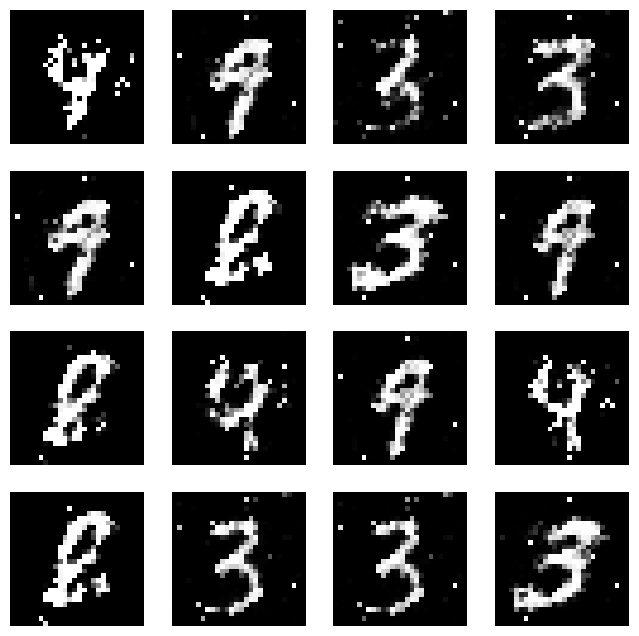

[Epoch  182/200] [Batch   99/938] ---> [D Loss: 0.151573] [G Loss: 3.112272]
[Epoch  182/200] [Batch  199/938] ---> [D Loss: 0.117396] [G Loss: 3.064385]
[Epoch  182/200] [Batch  299/938] ---> [D Loss: 0.055326] [G Loss: 2.950684]
[Epoch  182/200] [Batch  399/938] ---> [D Loss: 0.096369] [G Loss: 2.986233]
[Epoch  182/200] [Batch  499/938] ---> [D Loss: 0.154362] [G Loss: 5.155866]
[Epoch  182/200] [Batch  599/938] ---> [D Loss: 0.182334] [G Loss: 2.570503]
[Epoch  182/200] [Batch  699/938] ---> [D Loss: 0.256713] [G Loss: 2.394131]
[Epoch  182/200] [Batch  799/938] ---> [D Loss: 0.159640] [G Loss: 3.192997]
[Epoch  182/200] [Batch  899/938] ---> [D Loss: 0.117887] [G Loss: 4.059271]
[Epoch  183/200] [Batch   99/938] ---> [D Loss: 0.067917] [G Loss: 3.349172]
[Epoch  183/200] [Batch  199/938] ---> [D Loss: 0.122910] [G Loss: 3.837456]
[Epoch  183/200] [Batch  299/938] ---> [D Loss: 0.164018] [G Loss: 3.643441]
[Epoch  183/200] [Batch  399/938] ---> [D Loss: 0.127888] [G Loss: 6.065814]

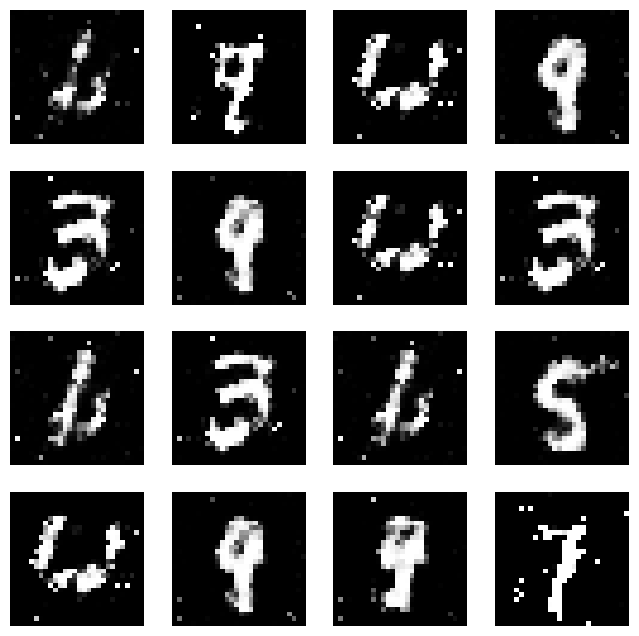

[Epoch  187/200] [Batch   99/938] ---> [D Loss: 0.068299] [G Loss: 4.022232]
[Epoch  187/200] [Batch  199/938] ---> [D Loss: 0.162906] [G Loss: 2.993822]
[Epoch  187/200] [Batch  299/938] ---> [D Loss: 0.118605] [G Loss: 2.767347]
[Epoch  187/200] [Batch  399/938] ---> [D Loss: 0.135989] [G Loss: 3.148238]
[Epoch  187/200] [Batch  499/938] ---> [D Loss: 0.113493] [G Loss: 2.858696]
[Epoch  187/200] [Batch  599/938] ---> [D Loss: 0.120035] [G Loss: 3.751225]
[Epoch  187/200] [Batch  699/938] ---> [D Loss: 0.119617] [G Loss: 2.443453]
[Epoch  187/200] [Batch  799/938] ---> [D Loss: 0.186968] [G Loss: 2.279132]
[Epoch  187/200] [Batch  899/938] ---> [D Loss: 0.166689] [G Loss: 3.646045]
[Epoch  188/200] [Batch   99/938] ---> [D Loss: 0.155061] [G Loss: 4.202044]
[Epoch  188/200] [Batch  199/938] ---> [D Loss: 0.119179] [G Loss: 3.115392]
[Epoch  188/200] [Batch  299/938] ---> [D Loss: 0.335126] [G Loss: 4.089510]
[Epoch  188/200] [Batch  399/938] ---> [D Loss: 0.236131] [G Loss: 3.636302]

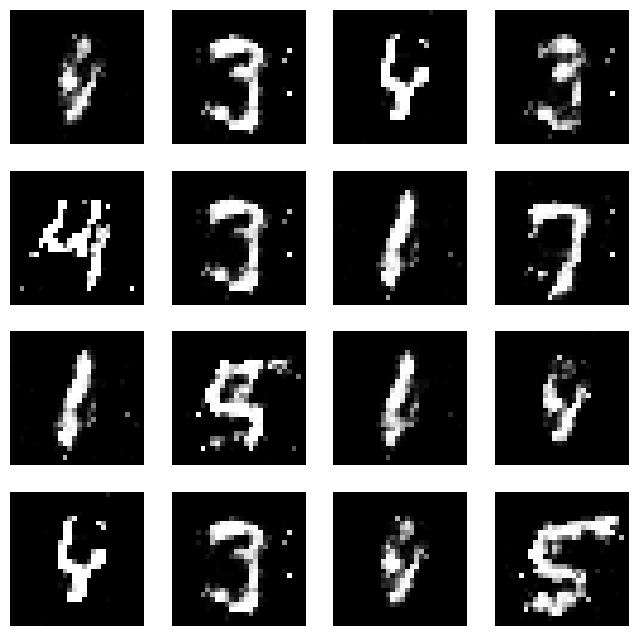

[Epoch  192/200] [Batch   99/938] ---> [D Loss: 0.140934] [G Loss: 3.154919]
[Epoch  192/200] [Batch  199/938] ---> [D Loss: 0.139970] [G Loss: 2.883223]
[Epoch  192/200] [Batch  299/938] ---> [D Loss: 0.068582] [G Loss: 4.138073]
[Epoch  192/200] [Batch  399/938] ---> [D Loss: 0.173903] [G Loss: 3.111290]
[Epoch  192/200] [Batch  499/938] ---> [D Loss: 0.229137] [G Loss: 2.234053]
[Epoch  192/200] [Batch  599/938] ---> [D Loss: 0.105770] [G Loss: 2.740437]
[Epoch  192/200] [Batch  699/938] ---> [D Loss: 0.263597] [G Loss: 4.035149]
[Epoch  192/200] [Batch  799/938] ---> [D Loss: 0.101427] [G Loss: 4.983814]
[Epoch  192/200] [Batch  899/938] ---> [D Loss: 0.076278] [G Loss: 2.580827]
[Epoch  193/200] [Batch   99/938] ---> [D Loss: 0.220513] [G Loss: 2.300306]
[Epoch  193/200] [Batch  199/938] ---> [D Loss: 0.082463] [G Loss: 4.272803]
[Epoch  193/200] [Batch  299/938] ---> [D Loss: 0.098035] [G Loss: 3.228870]
[Epoch  193/200] [Batch  399/938] ---> [D Loss: 0.142481] [G Loss: 3.019775]

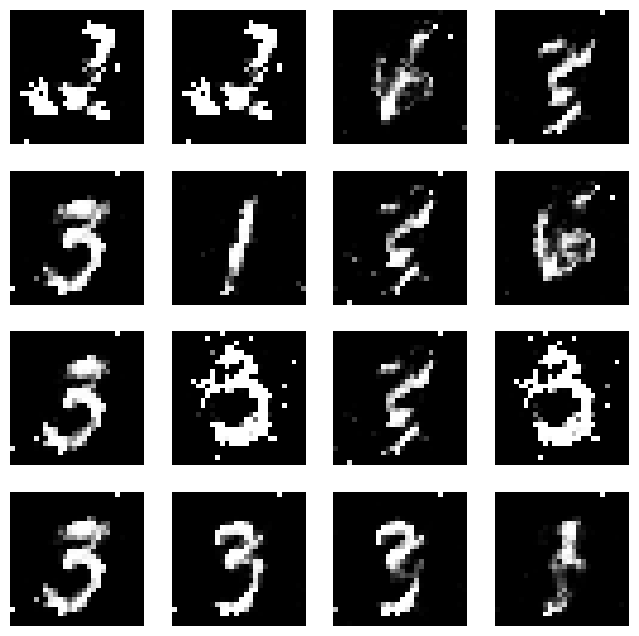

[Epoch  197/200] [Batch   99/938] ---> [D Loss: 0.063100] [G Loss: 3.619680]
[Epoch  197/200] [Batch  199/938] ---> [D Loss: 0.157820] [G Loss: 3.359846]
[Epoch  197/200] [Batch  299/938] ---> [D Loss: 0.104326] [G Loss: 4.080873]
[Epoch  197/200] [Batch  399/938] ---> [D Loss: 0.219816] [G Loss: 4.703347]
[Epoch  197/200] [Batch  499/938] ---> [D Loss: 0.100363] [G Loss: 7.104582]
[Epoch  197/200] [Batch  599/938] ---> [D Loss: 0.149566] [G Loss: 6.218026]
[Epoch  197/200] [Batch  699/938] ---> [D Loss: 0.119333] [G Loss: 3.480885]
[Epoch  197/200] [Batch  799/938] ---> [D Loss: 0.129590] [G Loss: 3.035324]
[Epoch  197/200] [Batch  899/938] ---> [D Loss: 0.166682] [G Loss: 5.191956]
[Epoch  198/200] [Batch   99/938] ---> [D Loss: 0.181481] [G Loss: 2.880680]
[Epoch  198/200] [Batch  199/938] ---> [D Loss: 0.179211] [G Loss: 3.467712]
[Epoch  198/200] [Batch  299/938] ---> [D Loss: 0.084752] [G Loss: 4.344343]
[Epoch  198/200] [Batch  399/938] ---> [D Loss: 0.219625] [G Loss: 5.916137]

In [17]:
import matplotlib.pyplot as plt
import torchvision
losses = []
images_for_gif = []
for epoch in range(1, epochs+1):
    for i, (images, _) in enumerate(data_loader):

        real_images = images.type(Tensor).to(device)
        real_output = Tensor(images.size(0), 1).fill_(1.0).to(device)   
        fake_output = Tensor(images.size(0), 1).fill_(0.0).to(device)


        # Training Discriminator
        optimizer_discriminator.zero_grad()
        discriminator_loss_real = adversarial_loss(discriminator(real_images), real_output)
        discriminator_loss_fake = adversarial_loss(discriminator(generated_images.detach()), fake_output)
        discriminator_loss = (discriminator_loss_real + discriminator_loss_fake) / 2
        discriminator_loss.backward()
        optimizer_discriminator.step()

        # Training Generator
        optimizer_generator.zero_grad()
        optimizer_discriminator.zero_grad()
        z = Tensor(np.random.normal(0, 1, (images.shape[0], latent_dim))).to(device)
        generated_images = generator(z)
        generator_loss = adversarial_loss(discriminator(generated_images), real_output).to(device)
        generator_loss.backward()
        optimizer_generator.step()

        

        if (i+1) % 100 == 0:
            print(f"[Epoch {epoch:=4d}/{epochs}] [Batch {i:=4d}/{len(data_loader)}] ---> "
                f"[D Loss: {discriminator_loss.item():.6f}] [G Loss: {generator_loss.item():.6f}]")

    if (epoch-1) % 5 == 0:
        fake_images = generated_images.reshape(generated_images.size(0), 1, 28, 28)
        plt.figure(figsize=(8, 8))
        for i in range(16):
            plt.subplot(4, 4, i+1)
            plt.imshow(fake_images[i].squeeze().cpu().detach().numpy(), cmap='gray')
            plt.axis('off')
        plt.show()
        torchvision.utils.save_image(fake_images, f'./mehrdad/justlinear/fake_images_with_cnn-{epoch+1}.png', nrow=4, normalize=True)



In [29]:
import imageio

images_for_gif = []
output_dir = './mehrdad/justlinear'
for i in range(1, 190,5):
    image_filename = f'./mehrdad/justlinear/fake_images_with_cnn-{i+1}.png'
    images_for_gif.append(imageio.imread(image_filename))
imageio.mimsave(f"{output_dir}/training_progressjustlinear.gif", images_for_gif, fps=4)



C:\Users\COMPUTER SHAHR\AppData\Local\Temp\ipykernel_12184\1726388561.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_for_gif.append(imageio.imread(image_filename))


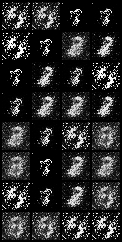

In [30]:
from IPython.display import Image
Image(filename=f'{output_dir}/training_progressjustlinear.gif', width=500, height=500)